In [1115]:
%%capture
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import operator
import seaborn as sns; sns.set()
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure
from scipy.ndimage import gaussian_filter
from statsmodels.formula.api import ols
from scipy.stats import t
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from landlab.utils.flow__distance import calculate_flow__distance
from landlab.utils import watershed
from scipy.odr import *

In [1116]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def slopeWindow(DEM_slope, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM_slope[0]; b = DEM_slope[1]; c = DEM_slope[2]
    d = DEM_slope[3]; e = DEM_slope[4]; f = DEM_slope[5]
    g = DEM_slope[6]; h = DEM_slope[7]; i = DEM_slope[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def slopeWindowMperM(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_m_per_m = rise_run
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_m_per_m
def planCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
    systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    plan_curvature = 2 * ((D*H**2 + E*G**2 - F*G*H) / (G**2 + H**2))
    return plan_curvature
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = -2 * (D*G**2 + E*H**2 + F*G*H) / (G**2 + H**2)
    return profile_curvature
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def differenceFromMeanElevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def ghFilter(gully_heads):
    """Reduce the number of candidate initial gully heads. The window size is custimizable through the 
    'footprint' argument. """
    surrounding_nodes_list = [];
    for i in range(0, num_values):
        if i != central_value:
            surrounding_nodes_list.append(gully_heads[i])
    
    surrounding_nodes_array = np.array(surrounding_nodes_list)
    non_zero_values = surrounding_nodes_array[surrounding_nodes_array > 0]
    if non_zero_values.size == 0:
        new_value = 0  
    else:
        if gully_heads[central_value] > 0 and np.min(non_zero_values) > gully_heads[central_value]:
            new_value = 1
        else:
            new_value = 0

    return new_value
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10
def catchmentDicts(area_grid, gn, gh_nodes):
    """Creates a dictionary of node ID:catcment area values."""
    area_dict = {}
    nodes = gh_nodes
    x_axis_length = gn.shape[1]
    for i in nodes:
        row = int(np.floor(i / x_axis_length))
        col = int(i - (row*x_axis_length))
        area = area_grid[row,col]
        area_dict[i] = area
    return area_dict
def upslopeDivergence(catchment_area_list, change_detection_factor, step_size, comparison_distance):
    
    """"Looks at whether catchment area is increasing at any point upstream of a gully head.
    
    - 'catchment_area_list' is an ordered list of node catchment areas moving upstream.
    
    - 'change_detection_factor' is the percentage increase required for the function to consider the change
    to represent a point of divergent flow.
    
    - 'step_size' is the number of grid cells to be compared in downstream to upstream groups. E.g. step_size == 1 
    will compare node 1 and node 2, but step_size == 2 will compare node 1 and 2 to node 3 and 4.
    
    - 'comparison_distance' is the distance between the downstream nodes being compared to upstream nodes."""
    
    max_value_length = len(catchment_area_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = catchment_area_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = catchment_area_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        required_catchment_area_increase = max(downstream_nodes) + (max(downstream_nodes) * change_detection_factor)
        
        if all(nodes >= required_catchment_area_increase for nodes in upstream_nodes):
            divergence = 1
            break
        else:
            divergence = 0
    return divergence
def findGullyHeadNode(gully_heads, grid_nodes, DEM, ca, input_DEM_resolution, 
                      distance_from_node, contributing_fraction, required_ca):
    
    catchment_area_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(np.ceil(distance_from_node/input_DEM_resolution))

    for i in gully_heads:

        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset = DEM[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        #################################################################################################
        ca_subset = ca[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        print('max ca: ', np.amax(ca_subset))
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');

        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);
        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        for j in range(0, distance_from_node):
            # Begin at the point (node) digitized as the intersection between the central flow line and the gully head.
            if j == 0:
                candidate_gridcell = catchment_outlet_id;
            else:
                candidate_gridcell = next_cell_downstream;
            # Get all receiver nodes of the current node.
            grid_cell_receiver_nodes = frp[candidate_gridcell,:];
            # Check if there is a node that receives >= 'contributing_fraction' from the current node.
            candidate_gridcell_list = [candidate_gridcell]
            node_ca_int = catchmentDicts(ca_subset, grid_nodes_sub, candidate_gridcell_list) # Find the node's contributing area.
            node_ca = node_ca_int[candidate_gridcell]
            print('Node id: ', candidate_gridcell, 'Catchment area: ', node_ca)
            if np.amax(grid_cell_receiver_nodes) < contributing_fraction or node_ca < required_ca:
                # Check if this is the last possible grid cell in the subset that could meet the criteria. If so, then there
                # is no suitable grid cell (node).
                if j == distance_from_node - 1:
                    catchment_area_dict[i] = 'No grid cell found'
                else:
                    # Otherwise, find the next downslope grid cell receiving the highest proportion of flow and check that 
                    # in the next iteration.
                    index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0];
                    next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
            else:
                # Find the position of the gridcell (node) that meets the criteria both in the subset and in the whole DEM
                # and record the node ID.
                final_node_index_lat =  np.where(grid_nodes_sub == candidate_gridcell)[0][0]
                final_node_index_lon =  np.where(grid_nodes_sub == candidate_gridcell)[1][0]
                
                # Find the offest between the index position of the node the loop ends on, and the index position of
                # the node that it started on. 
                final_lat_offset = final_node_index_lat - node_lat
                final_lon_offset = final_node_index_lon - node_lon
                # Then apply this offest to the index position of the starting node with respect top the whole DEM to find the 
                # node ID of the grid cell that met the criteria above.
                final_row_index = row_index + final_lat_offset
                final_col_index = col_index + final_lon_offset
                node_of_area_record = grid_nodes[final_row_index, final_col_index] # - this range is more than 1
                catchment_area_dict[i] = node_of_area_record
                catchment_area_node_list.append(node_of_area_record)
                break
                             
    return catchment_area_dict, catchment_area_node_list
def findPoint5mDownstream(gully_heads, grid_nodes, DEM, ca, input_DEM_resolution, 
                      distance_from_node):
    
    catchment_area_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(np.ceil(distance_from_node/input_DEM_resolution))

    for i in gully_heads:

        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset = DEM[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        #################################################################################################
        ca_subset = ca[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        print('max ca: ', np.amax(ca_subset))
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');

        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);
        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        for j in range(0, distance_from_node):
            # Begin at the point (node) digitized as the intersection between the central flow line and the gully head.
            if j == 0:
                candidate_gridcell = catchment_outlet_id;
            else:
                candidate_gridcell = next_cell_downstream;
            # Get all receiver nodes of the current node.
            grid_cell_receiver_nodes = frp[candidate_gridcell,:];
            # Check if there is a node that receives >= 'contributing_fraction' from the current node.
            candidate_gridcell_list = [candidate_gridcell]
            node_ca_int = catchmentDicts(ca_subset, grid_nodes_sub, candidate_gridcell_list) # Find the node's contributing area.
            node_ca = node_ca_int[candidate_gridcell]
            print('Node id: ', candidate_gridcell, 'Catchment area: ', node_ca)
            if j + 1 < distance_from_node:
                
                # Otherwise, find the next downslope grid cell receiving the highest proportion of flow and check that 
                # in the next iteration.
                index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0];
                next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
            else:
                print(j)
                # Find the position of the gridcell (node) that meets the criteria both in the subset and in the whole DEM
                # and record the node ID.
                final_node_index_lat =  np.where(grid_nodes_sub == candidate_gridcell)[0][0]
                final_node_index_lon =  np.where(grid_nodes_sub == candidate_gridcell)[1][0]
                
                # Find the offest between the index position of the node the loop ends on, and the index position of
                # the node that it started on. 
                final_lat_offset = final_node_index_lat - node_lat
                final_lon_offset = final_node_index_lon - node_lon
                # Then apply this offest to the index position of the starting node with respect top the whole DEM to find the 
                # node ID of the grid cell that met the criteria above.
                final_row_index = row_index + final_lat_offset
                final_col_index = col_index + final_lon_offset
                node_of_area_record = grid_nodes[final_row_index, final_col_index] # - this range is more than 1
                catchment_area_dict[i] = node_of_area_record
                catchment_area_node_list.append(node_of_area_record)
                break
                             
    return catchment_area_dict, catchment_area_node_list
def closest(lst, K): 
     angle_list = lst
     index_pos = (np.abs(angle_list - K)).argmin() 
     return angle_list[index_pos]  
def data_range(data):
    data_min = np.amin(data); data_max = np.amax(data)
    value_range = data_max - data_min
    return value_range
def checkGullyHead(dfme_list, step_size, comparison_distance, minimum_depth, elevation_of_gh):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        elevation_difference = min_downstream - mean_upstream
        print('minimum downstream value: ', min_downstream)
        print('mean upstream value: ', mean_upstream)
        print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference <= -0.2:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(end_of_downstream_nodes + np.round(comparison_distance/2))
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def checkGullyHeadElev(dfme_list, elev_list, step_size, comparison_distance, minimum_depth, elevation_of_gh, height_change):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_upstream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_upstream_nodes]
        
        #min_downstream = np.min(downstream_nodes)
        min_downstream = np.max(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        #std_upstream = np.std(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])
        elevation_difference = np.median(elev_list[start_of_upstream_nodes:end_of_upstream_nodes]) - np.median(elev_list[start_of_downstream_nodes:end_of_downstream_nodes])
        print('minimum downstream value: ', min_downstream)
        print('mean upstream value: ', mean_upstream)
        print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference >= height_change:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(end_of_downstream_nodes + np.round(comparison_distance/2))
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def upstreamDrainageLine(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, import_drainage_area, 
                         import_dfme, catchment_outlet_ids, step_size_m, comparison_distance_m,  
                         min_depth, gh_elevation):
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    final_gully_head_position_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    is_gully_head = {}

    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    gully_head_node_dict = {}
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
                
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        
        flattened_elevation = dem_subset.reshape(da.shape)
        
        #da_subset_copy = np.copy(import_drainage_area)
        import_da_subset = import_drainage_area[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        flattened_import_da = import_da_subset.reshape(da.shape)
        
        #dfme_subset_copy = np.copy(import_dfme)
        import_dfme_subset = import_dfme[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        flattened_import_dfme = import_dfme_subset.reshape(da.shape)
        
        grid_nodes_subset = grid_nodes[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        
        flattened_grid_nodes_subset = grid_nodes_subset.reshape(da.shape)
        
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.

        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        print(central_node)
        print(mg1.shape)
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.       

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        node_dfme_dict = {}
        node_elevation_dict = {}
        original_node_id_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_dfme_dict = {};
            upstream_elevation_dict = {};
            upstream_original_node_id = {}
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8 for the MFD8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j];
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value);
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_import_da));
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow;
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        original_node_id = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_grid_nodes_subset));
                        upstream_original_node_id.update({node_id_value:original_node_id});
                        node_dfme = np.amin(np.multiply(isolate_candidate_grid_cells, flattened_import_dfme));
                        upstream_dfme_dict.update({node_id_value:node_dfme});
                        node_elevation = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_elevation));
                        upstream_elevation_dict.update({node_id_value:node_elevation});

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = [];
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    print(primary_flow_direction_id);
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    node_elevation_dict[primary_flow_direction_id] = upstream_elevation_dict[primary_flow_direction_id]
                    node_dfme_dict[primary_flow_direction_id] = upstream_dfme_dict[primary_flow_direction_id]
                    original_node_id_dict[primary_flow_direction_id] = upstream_original_node_id[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)

                    
        dfme_along_central_drainage_line = []
        for key, value in node_dfme_dict.items():
            dfme_along_central_drainage_line.append(value)
        median_dfme_along_central_drainage_line = ndimage.median_filter(dfme_along_central_drainage_line, size=step_size_m)
        
        elevation_along_central_drainage_line = []
        for key, value in node_elevation_dict.items():
            elevation_along_central_drainage_line.append(value)
        median_elevation_along_central_drainage_line = ndimage.median_filter(elevation_along_central_drainage_line, size=step_size_m)
        print(elevation_along_central_drainage_line)
        
        original_node_id_along_central_drainage_line = []
        for key, value in original_node_id_dict.items():
            original_node_id_along_central_drainage_line.append(value)
        
        required_number_of_grid_cells = step_size + comparison_distance + step_size + 1
        if len(median_dfme_along_central_drainage_line) < required_number_of_grid_cells:
            is_gully_head[i] = 'not enough grid cells'
        else:
            print('node: ',i,)
            divergence_occuring, gully_head_node = checkGullyHeadElev(dfme_along_central_drainage_line,
                                                                      elevation_along_central_drainage_line,
                                                                     step_size, comparison_distance, 
                                                                      min_depth, gh_elevation, gh_relief)
            is_gully_head[i] = divergence_occuring
            gully_head_node_dict[i] = gully_head_node
            if isinstance(gully_head_node, str):
                pass
            else:
                final_gully_head_position_dict[i] = original_node_id_along_central_drainage_line[gully_head_node]
                
    return final_gully_head_position_dict, is_gully_head
def checkGullyEdges(dfme_list, step_size, comparison_distance, minimum_depth, elevation_of_gh):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptream_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        elevation_difference = min_downstream - mean_upstream
        #print('minimum downstream value: ', min_downstream)
        #print('mean upstream value: ', mean_upstream)
        #print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference <= -0.2:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(start_of_upstream_nodes)
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def checkGullyEdgesElev(dfme_list, elev_list,step_size, comparison_distance, minimum_depth, elevation_of_gh, height_change):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_upstream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_upstream_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        #std_upstream = np.std(upstream_nodes)
        std_upstream = np.std(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])
        elevation_difference = np.median(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])-np.median(elev_list[start_of_downstream_nodes:end_of_downstream_nodes])
        print('elevation difference: ', elevation_difference)
        #print('minimum downstream value: ', min_downstream)
        #print('mean upstream value: ', mean_upstream)
        #print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference >= height_change:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(start_of_upstream_nodes)
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def thresholdLine(regression_dataset, area_column_title, slope_column_title):
    cooks_d_cutoff = 4 / len(regression_dataset)

    regression_dataset['log_area'] = np.log10(regression_dataset[area_column_title])
    regression_dataset['log_slope'] = np.log10(regression_dataset[slope_column_title])

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = m.params[1]

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def upstreamSlope(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, import_drainage_area, 
                         import_dfme, catchment_outlet_ids, step_size_m, comparison_distance_m,  
                         slope_above_head):
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    final_gully_head_position_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    is_gully_head = {}
    slope_dict = {}
    slope_at_head = {}
    elevation_at_head = {}
    
    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    gully_head_node_dict = {}
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        
        #da_subset_copy = np.copy(import_drainage_area)
        import_da_subset = import_drainage_area[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        flattened_import_da = import_da_subset.reshape(da.shape)
        
        #dfme_subset_copy = np.copy(import_dfme)
        import_dfme_subset = import_dfme[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        flattened_import_dfme = import_dfme_subset.reshape(da.shape)
        
        grid_nodes_subset = grid_nodes[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        
        flattened_grid_nodes_subset = grid_nodes_subset.reshape(da.shape)
        
        flattened_elevation_nodes = dem_subset.reshape(da.shape)
        
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.

        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        print(central_node)
        print(mg1.shape)
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.
        slope = generic_filter(dem_subset, slopeWindowMperM,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

        flattened_slope = slope.reshape(da.shape)

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        slope_mean_dict = {}
        node_dfme_dict = {}
        node_elevation_dict = {}
        original_node_id_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            target_distance = int(np.floor(slope_above_head/input_DEM_resolution)) 
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_slope_dict = {};
            upstream_dfme_dict = {};
            upstream_elevation_dict = {};
            upstream_original_node_id = {}
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j]
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_import_da))
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        node_slope = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_slope))
                        upstream_slope_dict.update({node_id_value:node_slope})
                        node_elevation = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_elevation_nodes))
                        upstream_elevation_dict.update({node_id_value:node_elevation})
                        original_node_id = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_grid_nodes_subset))
                        upstream_original_node_id.update({node_id_value:original_node_id})
                        node_dfme = np.amin(np.multiply(isolate_candidate_grid_cells, flattened_import_dfme))
                        upstream_dfme_dict.update({node_id_value:node_dfme})

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = []
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    print(primary_flow_direction_id)
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    slope_mean_dict[primary_flow_direction_id] = upstream_slope_dict[primary_flow_direction_id]
                    node_dfme_dict[primary_flow_direction_id] = upstream_dfme_dict[primary_flow_direction_id]
                    node_elevation_dict[primary_flow_direction_id] = upstream_elevation_dict[primary_flow_direction_id]
                    original_node_id_dict[primary_flow_direction_id] = upstream_original_node_id[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)
                    if d == target_distance:
                        print(target_distance, ' ', target_distance * input_DEM_resolution)
                        slope_at_head[i] = [upstream_slope_dict[primary_flow_direction_id],i]
                        elevation_at_head[i] = [upstream_elevation_dict[primary_flow_direction_id],i]
                    else:
                        pass    
                
    return slope_at_head, elevation_at_head
def removeSmallFeatures(x):
    """ """
    if x[central_value] == 0:
        keep_gh = 0
    elif np.nansum(x) <= np.floor(window_size/2):
        keep_gh = 0
    else:
        keep_gh = 1
    return keep_gh
def get_values(my_dict):
    convergence_points_to_keep = []
    gully_heads_to_keep = []
    for key, value in my_dict.items():
        convergence_points_to_keep.append(key)
        gully_heads_to_keep.append(value)
    return convergence_points_to_keep, gully_heads_to_keep
def gullyUnknownAngle(lat_dis, lon_dis):
    """Find ... """

    #################################################################################################
    # For gullies perfectly aligned along cardinal dorections. Quadrant is set to zero because they are all on boundaries.
    if lon_dis == 0 and lat_dis < 0:
        exact_angle = 180
        quadrant = 0
        
    elif lon_dis == 0 and lat_dis > 0:
        exact_angle = 0
        quadrant = 0
        
    elif lat_dis == 0 and lon_dis > 0:
        exact_angle = 90
        quadrant = 0
        
    elif lat_dis == 0 and lon_dis < 0:
        exact_angle = 270
        quadrant = 0
    #################################################################################################
    # For gullies of all otehr abgles.
    elif lat_dis > 0 and lon_dis > 0:
        angle_max = 90
        angle_min = 0
        quadrant = 1
        print('Quadrant = Q1', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
    
    elif lat_dis > 0 and lon_dis < 0:
        angle_max = 360
        angle_min = 270
        quadrant = 2
        print('Quadrant = Q2', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
        
    elif lat_dis < 0 and lon_dis < 0:
        angle_max = 270
        angle_min = 180
        quadrant = 3
        print('Quadrant = Q3', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
        
    else:
        angle_max = 180
        angle_min = 90
        quadrant = 4
        print('Quadrant = Q4', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))   

    if quadrant == 1:
        gully_orientation = angle_max - theta_a
    elif quadrant == 2:
        gully_orientation = angle_min + theta_a
    elif quadrant == 3:
        gully_orientation = angle_max - theta_a
    elif quadrant == 4:
        gully_orientation = angle_min + theta_a
    else:
        gully_orientation = exact_angle
        
    return gully_orientation
class GullyOrientation:
    """Convention for first direction to take (d1) in cross section method 
    follows directional convention used in Landlab."""
    possible_angles = np.array([90, 0, 270, 180, 45, 315, 225, 135, 360])
    def __init__(self, angle, outlet, grid_shape):
        self.angle = angle
        self.outlet = outlet
        self.grid_shape = grid_shape
        idx = (np.abs(self.possible_angles - self.angle)).argmin() 
        find_angle_from_list = self.possible_angles[idx]
        self.closest_angle = find_angle_from_list

    def cross_section(self, line_length):
        cross_section_nodes_d1 = [self.outlet]
        cross_section_nodes_d2 = [self.outlet]
        if self.closest_angle == 90 or self.closest_angle == 270:
            print('east-west gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - self.grid_shape[1]
                next_node_d2 = current_node_d2 + self.grid_shape[1]
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 0 or self.closest_angle == 180 or self.closest_angle == 360:
            print('north-south gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 + 1
                next_node_d2 = current_node_d2 - 1
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 45 or self.closest_angle == 225:
            print('northeast-southwest gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] + 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] + 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)
        else:
            print('northwest-southeast gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] - 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] - 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        cross_section_nodes = np.array(list(set(cross_section_nodes_d1 + cross_section_nodes_d2)))
        return cross_section_nodes
def assignDirection(cross_section_df, approximate_angle):

    d1 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'DFME'].values.tolist()
    d1.reverse() # Reversed because starts from end for left side only.
    d1_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Node'].values.tolist()
    d1_nodes.reverse()
    d2 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'DFME'].values.tolist()
    d2_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Node'].values.tolist()
   
    return d1, d1_nodes, d2, d2_nodes
def assignDirectionElev(cross_section_df, approximate_angle):

    d1 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Elevation'].values.tolist()
    d1.reverse() # Reversed because starts from end for left side only.
    d1_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Node'].values.tolist()
    d1_nodes.reverse()
    d2 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Elevation'].values.tolist()
    d2_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Node'].values.tolist()
   
    return d1, d1_nodes, d2, d2_nodes
def pointsAlongGully(node_at_gully_edge, gully_angle_to_follow, distance, grid_node_array):
    
    """Can do both left and right sides."""

    if gully_angle_to_follow == 0 or gully_angle_to_follow == 360:
        print('north_to_south gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1])

    elif gully_angle_to_follow == 180:
        print('south_to_north gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1])

    elif gully_angle_to_follow == 270:
        print('west_to_east gully')
        node_next_to_head = node_at_gully_edge - 5
        
    elif gully_angle_to_follow == 90:
        print('east_to_west gully')
        node_next_to_head = node_at_gully_edge + 5
        
    elif gully_angle_to_follow == 45:
        print('northeast_to_southwest gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1] - 1)
        
    elif gully_angle_to_follow == 225:
        print('southwest_to_notheast gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1] - 1)
        
    elif gully_angle_to_follow == 315:
        print('northwest_to_southeast gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1] + 1)
        
    else:
        print('southeast_to_northwest gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1] + 1)

    return node_next_to_head
def getSlopeValues(node_list, slope_grid, grid_node_array):
    slope_values_dict = {}
    for i in node_list:
        result = np.where(grid_node_array == i);
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        slope_value = slope_grid[row_index,col_index];
        slope_values_dict[i] = np.round(slope_value, 3);
    return slope_values_dict
def get_keys(value_list, my_dict):
    gh_node_list = []
    for node_value in value_list:   
        for key, value in my_dict.items(): 
             if node_value == value:
                    gh_node_list.append(key)
  
    return gh_node_list
def hengl2003TangentialCurvature(DEM, cellsize):
    """This process is taken from Hengl 2003."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    tangential_curvature_knc = -1*(D*H**2 - (2*F*G*H)+ E*G**2) / ((G**2+H**2)*np.sqrt(1+G**2+H**2))
    return tangential_curvature_knc
def hengl2003ProfileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    profile_curvature_kns = -1*(D*G**2 +(2*F*G*H)+ E*H**2) / ((G**2+H**2)*np.sqrt((1+G**2+H**2)**3))
    return profile_curvature_kns
def hengl2003GeodesicTorsion(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    contour_geodesic_torsion_tgc = (G*H*(D-E) - F*(G**2-H**2)) / ((G**2+H**2)*(1+G**2+H**2))
    return contour_geodesic_torsion_tgc
def thresholdLineNoCooks(regression_dataset, area_column_title, slope_column_title):

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = m.params[1]

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        l_intercept = lowest_points_m.params[0]
        l_slope = lowest_points_m.params[1]
        intercept = 10**lowest_points_m.params[0]
        slope = lowest_points_m.params[1] * -1 
            
    return l_slope, l_intercept, slope, intercept, corrected_set
def thresholdLineFixedB(regression_dataset, area_column_title, slope_column_title, b):
    cooks_d_cutoff = 4 / len(regression_dataset)

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = -1*b

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        final_corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            l_intercept = 'not enough data'
            l_slope = 'not enough data'
            print('not enough data')
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def thresholdLineFixedB_r(regression_dataset, area_column_title, slope_column_title, b):
    cooks_d_cutoff = 4 / len(regression_dataset)

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = -1*b

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope < model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        final_corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            l_intercept = 'not enough data'
            l_slope = 'not enough data'
            print('not enough data')
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def thresholdLineOnlyCooks(regression_dataset, area_column_title, slope_column_title):
    cooks_d_cutoff = 4 / len(regression_dataset)
    if len(regression_dataset) < 3:
        corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        m = ols('log_slope ~ log_area',regression_dataset).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            corrected_set = regression_dataset.drop(high_value_list, axis='index')
        else:
            corrected_set = regression_dataset
            
    return corrected_set
            

In [1350]:
input_DEM_resolution = 1
working_resolution = 1
location = (r'C:\PhD\manuscript\automated_topographic_thresholds\data\fann')
os.chdir(location)
input_geotiff = gdal.Open('fann_1.tif')
y = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
x = scipy.ndimage.zoom(y, input_DEM_resolution / working_resolution, order = 1)
empty_grid_rows = roundup(x.shape[0])
empty_grid_cols = roundup(x.shape[1])
input_DEM = np.zeros([empty_grid_rows,empty_grid_cols])
input_DEM[:x.shape[0], :x.shape[1]] = x

### Sub-catchment mask

In [1351]:
input_geotiff = gdal.Open('fann_1_c.tif')
y = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
x = scipy.ndimage.zoom(y, input_DEM_resolution / working_resolution, order = 1)
empty_grid_rows = roundup(x.shape[0])
empty_grid_cols = roundup(x.shape[1])
mask_DEM = np.zeros([empty_grid_rows,empty_grid_cols])
mask_DEM[:x.shape[0], :x.shape[1]] = x
dem_mask = 1 - mask_DEM

# Model parameters

In [1352]:
# Initial gully heads
dfme_threshold = -0.2 # Gets used at the start and as part of upslopeDrainageLine function.
threshold_minimum_drainage = 0.05
minimum_gully_length = 10
tangential_curvature_threshold = -0.05
profile_curvature_threshold = 0.05
convergence_threshold = 0.8

gh_relief = 0.2
gh_min_elev = -0.2

In [1353]:
step_s = 3
comp_d = 3

In [1354]:
mask_DEM.shape

(950, 1070)

In [1355]:
input_DEM.shape

(950, 1070)

# Smooth DEM with a gaussian filter

In [1356]:
sigma = 1
truncate = 3

copy_dem = np.copy(input_DEM)
smoothed_dem = gaussian_filter(copy_dem, sigma=sigma, truncate = truncate)

# Prepare ModelGrid

In [1357]:
flow_acc_surf = np.copy(smoothed_dem).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

In [1358]:
sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorD8');
fa.run_one_step();
fd = FlowDirectorD8(mg, 'topographic__elevation');
fd.run_one_step();

In [1359]:
da = np.array(mg.at_node['drainage_area'].round(4))
frn = mg.at_node['flow__receiver_node']
drainage_area = np.flip(da.reshape(mg.shape), 0);
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0)
flow_rec_surf_rows = cols * rows;
catchment_area_d8 = da.reshape(mg.shape) / (10000 * (1/working_resolution**2))

# Fill sinks and run single direction flow routing algorithm.

In [1360]:
flow_acc_surf = np.copy(smoothed_dem).astype('float64');
#################################################################################################
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

In [1361]:
sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
fa.run_one_step();
fd = FlowDirectorMFD(mg, 'topographic__elevation', diagonals = True);
fd.run_one_step();

da = np.array(mg.at_node['drainage_area'].round(4))
catchment_area_ha = np.divide(da.reshape(mg.shape), (100/working_resolution)**2)
frn = mg.at_node['flow__receiver_node']
drainage_area = np.flip(da.reshape(mg.shape), 0);
frp = np.array(mg.at_node['flow__receiver_proportions']);
ns = np.flip(mg.status_at_node.reshape(mg.shape), 0)
flow_rec_surf_rows = cols * rows;
flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);

catchment_area = da.reshape(mg.shape) / (10000 * (1/working_resolution**2))

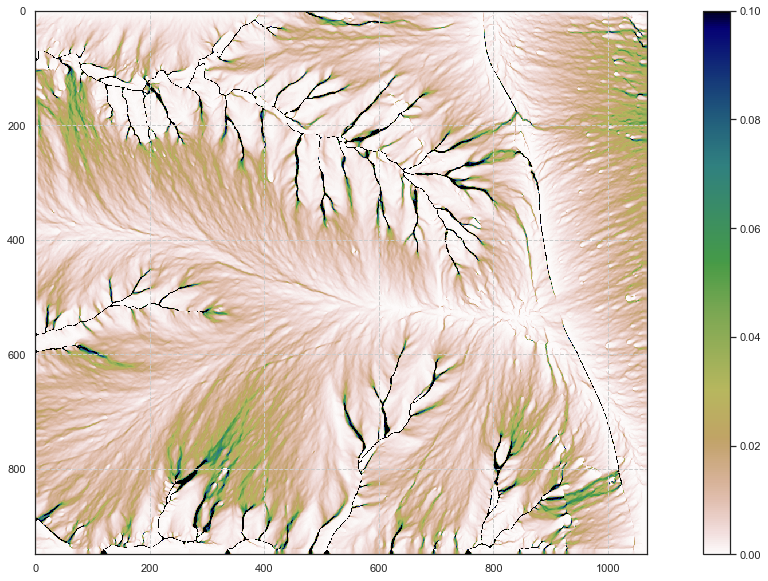

In [1362]:
plt.figure(figsize=(20,10));
plt.imshow(catchment_area, cmap="gist_earth_r", vmax = .1);
plt.colorbar();

# Look at ModelGrid properties.

In [1363]:
mg.at_node.keys()

['topographic__elevation',
 'sediment_fill__depth',
 'water__unit_flux_in',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'flow__receiver_proportions',
 'topographic__steepest_slope',
 'drainage_area',
 'flow__data_structure_delta',
 'flow__upstream_node_order',
 'surface_water__discharge',
 'flow__sink_flag']

# Compute tangential curvature

In [1364]:
tangential_curvature_smoothed= generic_filter(smoothed_dem, hengl2003TangentialCurvature, 
                footprint= rectangleWindow(3,3), 
                mode='constant', extra_arguments = (working_resolution,));

tangential_curvature_smoothed[tangential_curvature_smoothed<-0.3] = -0.3
tangential_curvature_smoothed[tangential_curvature_smoothed>0.3] = 0.3

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1316: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


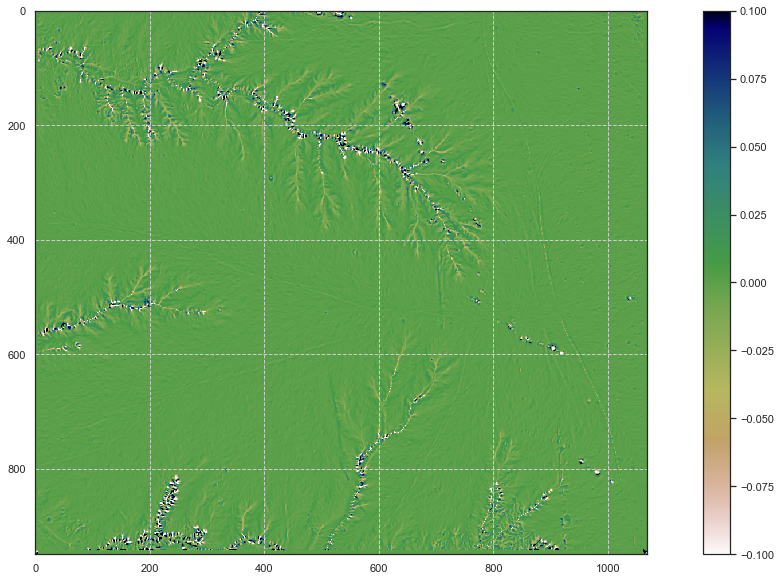

In [1365]:
plt.figure(figsize=(20,10));
plt.imshow(tangential_curvature_smoothed, cmap="gist_earth_r", vmin = -0.1, vmax = 0.1);
plt.colorbar();

In [1366]:
profile_curvature_smoothed= generic_filter(smoothed_dem, hengl2003ProfileCurvature, 
                footprint= rectangleWindow(3,3), 
                mode='constant', extra_arguments = (working_resolution,));

profile_curvature_smoothed[profile_curvature_smoothed<-0.3] = -0.3
profile_curvature_smoothed[profile_curvature_smoothed>0.3] = 0.3

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1329: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


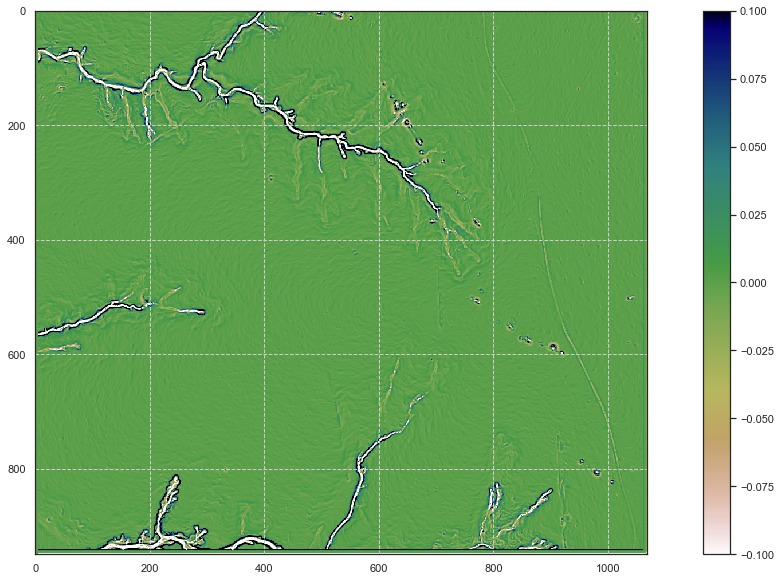

In [1367]:
plt.figure(figsize=(20,10));
plt.imshow(profile_curvature_smoothed, cmap="gist_earth_r", vmin = -.1, vmax = .1);
plt.colorbar();

# Mask curvature in channels

In [1368]:
mask_tc = np.copy(tangential_curvature_smoothed)

mask_tc[mask_tc>tangential_curvature_threshold] = 0
mask_tc[mask_tc<=tangential_curvature_threshold] = 1
mask_tc_NaNs = np.isnan(mask_tc)
mask_tc[mask_tc_NaNs] = 0

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.


In [1369]:
mask_pc = np.copy(profile_curvature_smoothed)

mask_pc[mask_pc>profile_curvature_threshold] = 1
mask_pc[mask_pc<=profile_curvature_threshold] = 0
mask_pc_NaNs = np.isnan(mask_pc)
mask_pc[mask_pc_NaNs] = 0

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.


In [1370]:
shape = 5
central_value = find_median_value(circleWindow(shape))
num_values = number_of_values(circleWindow(shape))

DFME = generic_filter(smoothed_dem, differenceFromMeanElevation, 
                        footprint= circleWindow(shape), mode='nearest');
DFME[DFME<-10]=-10
DFME[DFME>=10]=10

In [1371]:
dfme_copy = np.copy(DFME)
dfme_copy[dfme_copy > dfme_threshold] = 0
dfme_copy[dfme_copy < dfme_threshold] = 1

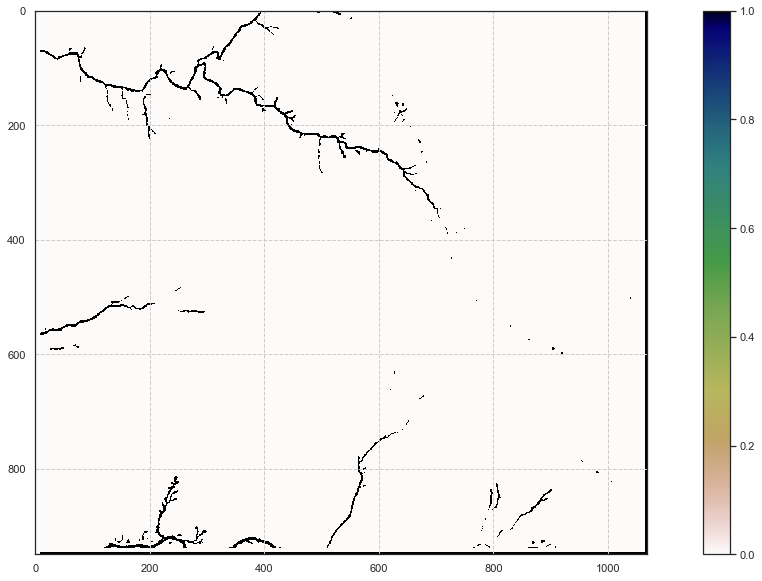

In [1372]:
plt.figure(figsize=(20,10));
plt.imshow(dfme_copy, cmap="gist_earth_r");
plt.colorbar();

In [1373]:
mask_curvature = mask_tc + mask_pc + dfme_copy
mask_curvature[mask_curvature > 1]= 1

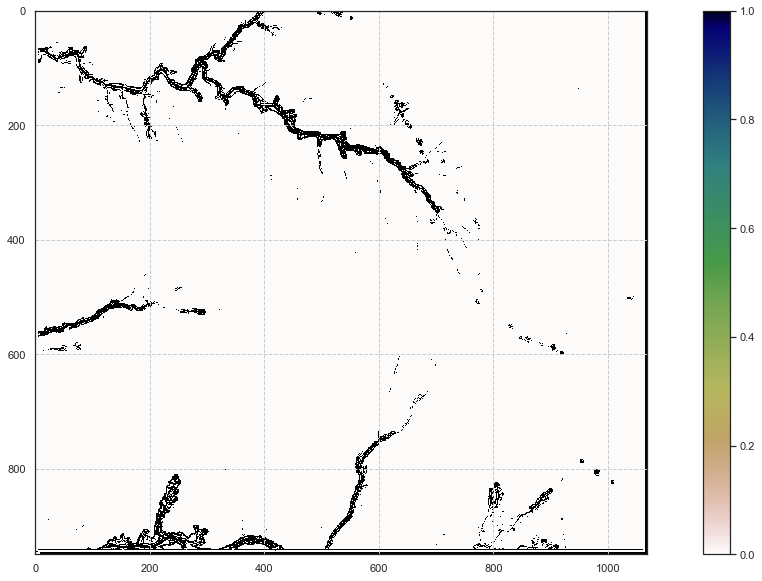

In [1374]:
plt.figure(figsize=(20,10));
plt.imshow(mask_curvature, cmap="gist_earth_r");
plt.colorbar();

# Create a drainage area mask 

In [1375]:
drainage_area_mask = np.copy(catchment_area)
drainage_area_mask[drainage_area_mask>=threshold_minimum_drainage] = 1
drainage_area_mask[drainage_area_mask<threshold_minimum_drainage] = 0

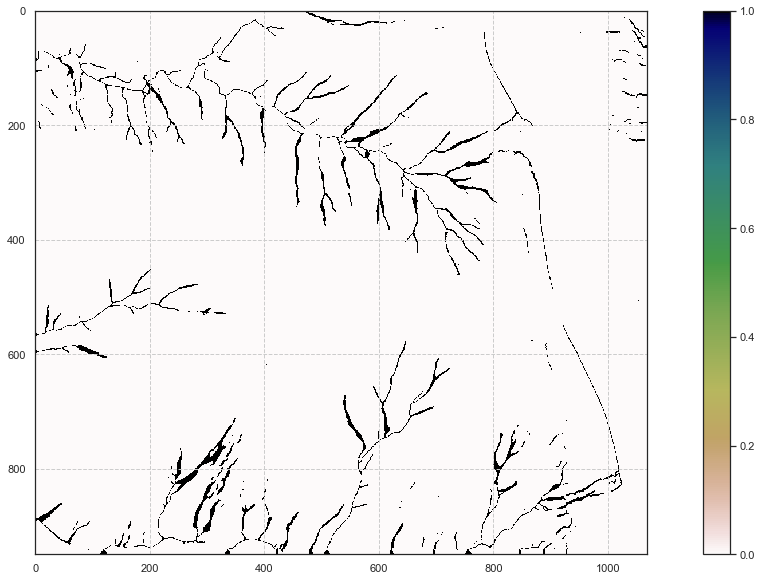

In [1376]:
plt.figure(figsize=(20,10));
plt.imshow(drainage_area_mask, cmap="gist_earth_r");
plt.colorbar();

In [1377]:
find_channels = drainage_area_mask * mask_curvature

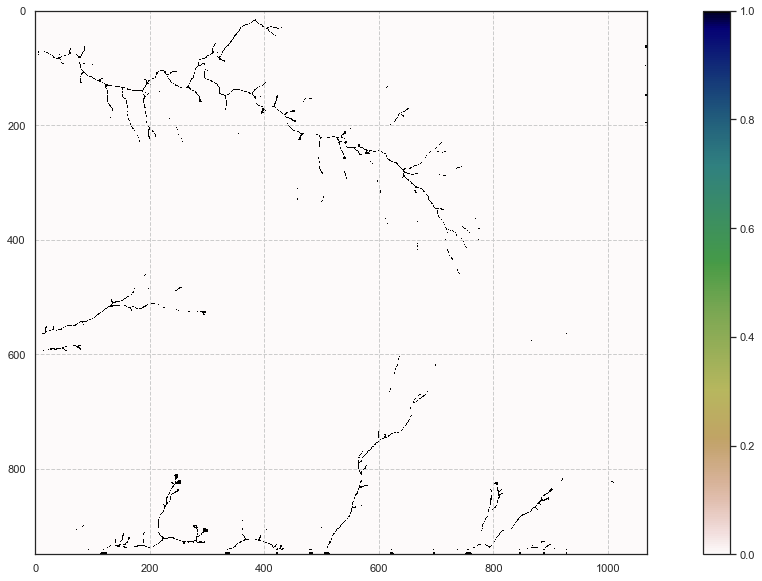

In [1378]:
plt.figure(figsize=(20,10));
plt.imshow(find_channels, cmap="gist_earth_r");
plt.colorbar();

In [1379]:
gully_lengths = np.copy(find_channels)
gully_lengths[gully_lengths > 0] = 1

for i in range(1, minimum_gully_length + 1):
    if i == 1:
        input_features = gully_lengths
    else:
        input_features = remove_small_features
    window_size = i*2+1
    central_value = find_median_value(rectangleWindow(window_size, window_size))
    remove_small_features = generic_filter(input_features, 
                                            removeSmallFeatures, 
                                           footprint= rectangleWindow(window_size,window_size), 
                                           mode='constant');
    

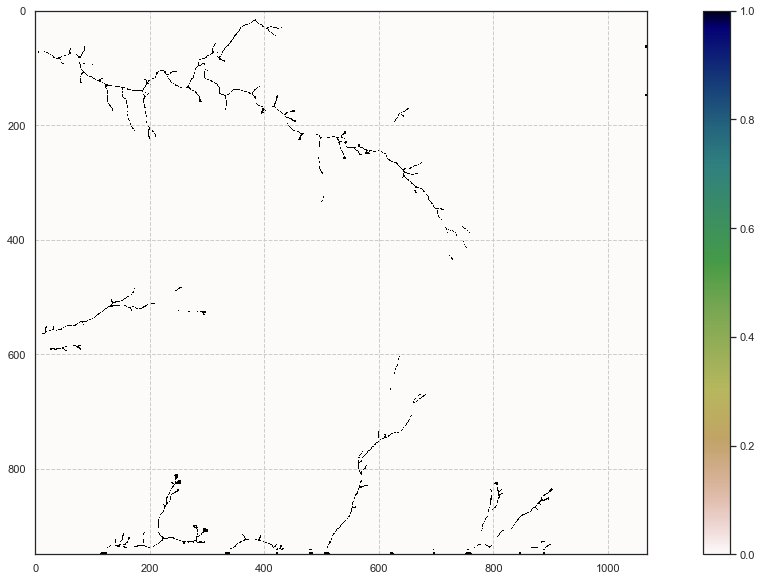

In [1380]:
plt.figure(figsize=(20,10));
plt.imshow(remove_small_features, cmap="gist_earth_r");
plt.colorbar();

# Isolate drainage lines in gullies and channels

In [1381]:
gully_internal_drainage = remove_small_features * catchment_area

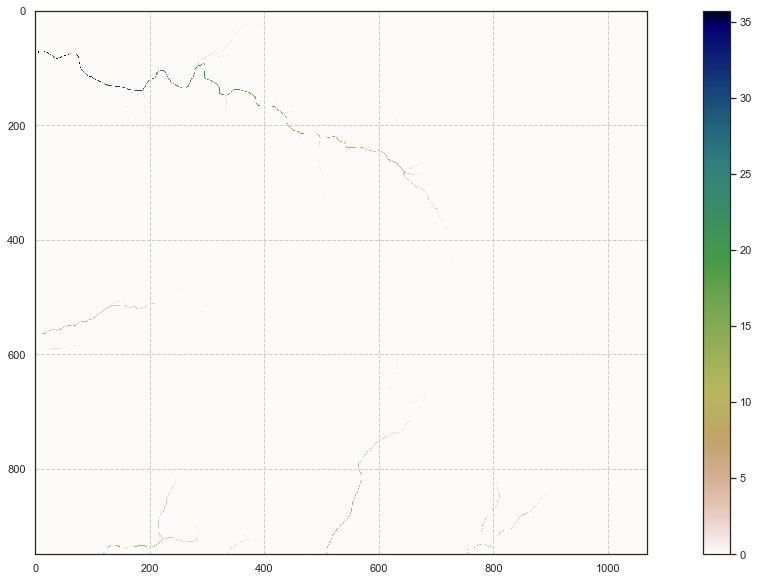

In [1382]:
plt.figure(figsize=(20,10));
plt.imshow(gully_internal_drainage, cmap="gist_earth_r");
plt.colorbar();

# Use D8 to find a single gully head grid cell.

In [1383]:
gully_internal_drainage[gully_internal_drainage > 0] = 1

In [1384]:
maximum_drainage = gully_internal_drainage * catchment_area_d8
maximum_drainage[maximum_drainage < threshold_minimum_drainage] = 0

# Mask the output by the remove_small_features grid. 

In [1385]:
gully_internal_maximum_drainage = remove_small_features * maximum_drainage

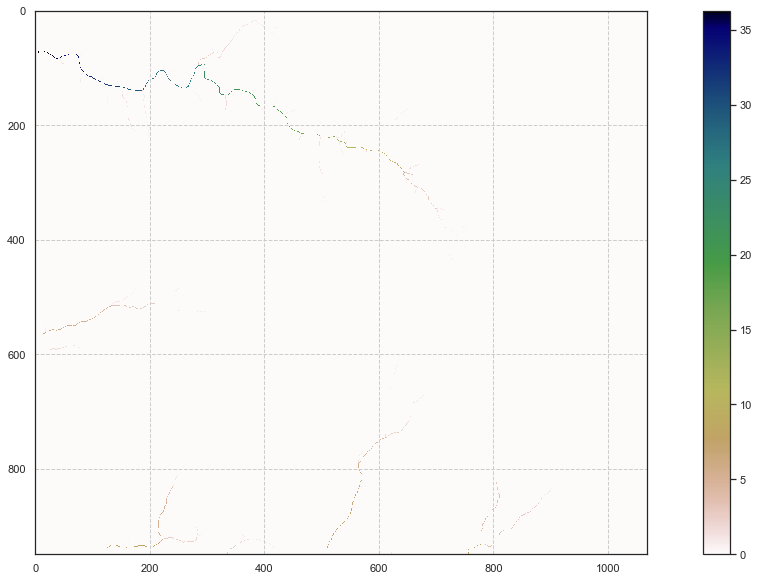

In [1386]:
plt.figure(figsize=(20,10));
plt.imshow(gully_internal_maximum_drainage, cmap="gist_earth_r");
plt.colorbar();

# Find initial gully heads.

In [1387]:
shape = 3
central_value = find_median_value(rectangleWindow(shape, shape))
num_values = number_of_values(rectangleWindow(shape, shape))

filtered_gully_head_points = generic_filter(gully_internal_maximum_drainage, 
                            ghFilter, footprint= rectangleWindow(shape,shape), mode='constant');

# Count first estimate of number of gully heads

In [1388]:
np.sum(filtered_gully_head_points)

194.0

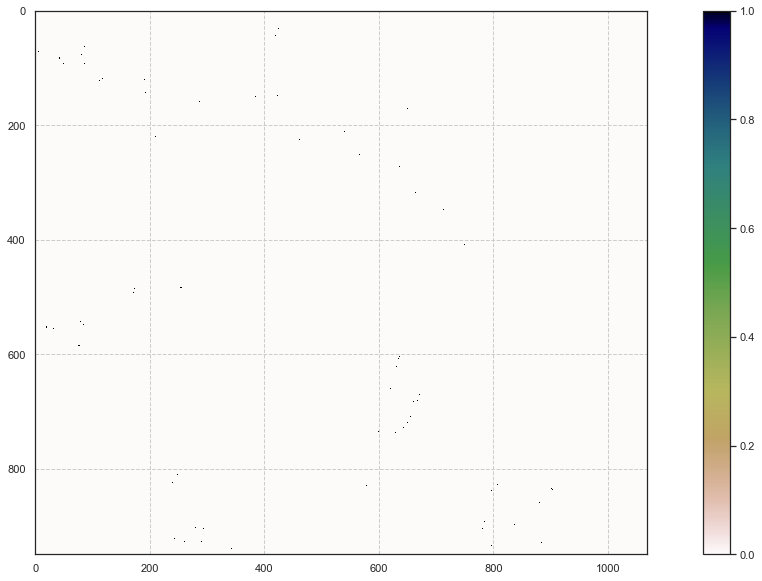

In [1389]:
plt.figure(figsize=(20,10));
plt.imshow(filtered_gully_head_points, cmap="gist_earth_r");
plt.colorbar();

In [1390]:
dfme_mask = 1 - dfme_copy

In [1391]:
gully_heads_masked_by_dfme = filtered_gully_head_points * dfme_mask

In [1392]:
np.sum(gully_heads_masked_by_dfme)

127.0

## Mask by catchment boundary

In [1393]:
masked_gully_heads = gully_heads_masked_by_dfme * dem_mask 

## Look at number of remaining gully heads

In [1394]:
np.sum(masked_gully_heads)

76.0

## Isolate all gully head nodes

In [1395]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape));
grid_nodes_float = grid_nodes.astype('float64');
find_nodes = np.multiply(masked_gully_heads, grid_nodes);

## Create array of only gully head nodes 

In [1396]:
gh_array = np.unique(find_nodes).astype('int32');

## Turn gully head node array into a list and remove the value 0

In [1397]:
gh_list = gh_array.tolist();
gh_list.remove(0);

### The final variable in the function below sets the threshold catchment area at the point of convergence required to keep the gully head as a candidate. Default set to 0.1 ha.

## Work through list finding index positions of each node. catchment_area_node_list is the list of nodes where flow converges to a single cell.

In [1398]:
catchment_area_dict, catchment_area_node_list = findGullyHeadNode(gh_list, grid_nodes, input_DEM, catchment_area,
                                                                  input_DEM_resolution, 10, convergence_threshold, threshold_minimum_drainage)        

max ca:  0.23200391
Node id:  220 Catchment area:  0.10745066
Node id:  219 Catchment area:  0.08581076
Node id:  239 Catchment area:  0.1266275
Node id:  238 Catchment area:  0.10067484
Node id:  258 Catchment area:  0.15317387
Node id:  257 Catchment area:  0.10616835
max ca:  0.45336912
Node id:  220 Catchment area:  0.18396831
Node id:  241 Catchment area:  0.20755766
Node id:  261 Catchment area:  0.22349867
Node id:  282 Catchment area:  0.29901091
max ca:  0.88085033
Node id:  220 Catchment area:  0.45807527
Node id:  240 Catchment area:  0.5826192
Node id:  260 Catchment area:  0.69744341
Node id:  259 Catchment area:  0.56553361
max ca:  1.21338897
Node id:  220 Catchment area:  0.49486987
Node id:  219 Catchment area:  0.54190397
Node id:  218 Catchment area:  0.50505335
Node id:  238 Catchment area:  0.69058722
max ca:  0.73472059
Node id:  220 Catchment area:  0.0898158
Node id:  199 Catchment area:  0.11801186
Node id:  178 Catchment area:  0.17190034
Node id:  157 Catchme

Node id:  220 Catchment area:  0.89339446
Node id:  241 Catchment area:  0.81875028
Node id:  262 Catchment area:  0.77268926
Node id:  283 Catchment area:  0.70786158
Node id:  303 Catchment area:  1.23956697
max ca:  4.43170526
Node id:  220 Catchment area:  0.64359714
Node id:  241 Catchment area:  0.5048627
Node id:  261 Catchment area:  0.68665534
Node id:  260 Catchment area:  0.34936135
max ca:  4.43813663
Node id:  220 Catchment area:  0.1126114
max ca:  1.05694662
Node id:  220 Catchment area:  0.11932523
Node id:  241 Catchment area:  0.13846144
Node id:  261 Catchment area:  0.18571109
Node id:  281 Catchment area:  0.24402926
Node id:  301 Catchment area:  0.22241123
Node id:  323 Catchment area:  0.37986942
max ca:  2.77653383
Node id:  220 Catchment area:  1.1377204
Node id:  241 Catchment area:  1.18890339
Node id:  262 Catchment area:  1.22539867
max ca:  6.16308341
Node id:  220 Catchment area:  0.07627738
Node id:  219 Catchment area:  0.10781355
Node id:  218 Catchme

# Create a list of all gully head nodes that had a valid convergence point.

### In the catchment_area_dict the key is the initial gully head node and the value is the node where flow converges to a single cell (cp).

## This is a list of all initial gully heads to keep. Can have duplicates because some gully heads share a convergence point.

In [1399]:
gully_heads_to_keep = get_keys(catchment_area_node_list, catchment_area_dict)
initial_gully_heads = np.isin(grid_nodes,gully_heads_to_keep).astype('int64')
initial_gully_head_and_cp_df = pd.DataFrame.from_dict(catchment_area_dict, orient='index')
initial_head_column = np.array(initial_gully_head_and_cp_df.index)
initial_gully_head_and_cp_df['initial'] = initial_head_column
initial_gully_head_and_cp_df.rename(columns={0: 'cp'}, inplace=True)

## This is a grid of all convergence points.

In [1400]:
initial_cp_nodes = np.isin(grid_nodes,catchment_area_node_list).astype('int64')

In [1401]:
initial_gh_nodes = np.isin(grid_nodes,initial_gully_head_and_cp_df['initial'].values).astype('int64')

In [1402]:
np.sum(initial_cp_nodes)

72

# Can collect catchment area at this stage but need a reliable estimate of it (from a drainage area grid run with overlapping tiles).

In [1403]:
cp_da_dict = {}

for i in catchment_area_node_list:
    result = np.where(grid_nodes == i);
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    cp_da = catchment_area[row_index,col_index];
    cp_da_dict[i] = np.round(cp_da, 5);
    
cp_da_df = pd.DataFrame.from_dict(cp_da_dict, orient='index')
cp_da_df['cp'] = cp_da_df.index
initial_head_cp_df = initial_gully_head_and_cp_df.merge(cp_da_df, on="cp", how = 'inner')
initial_head_cp_df.rename(columns={0: 'area'}, inplace=True)


In [1404]:
initial_gh_da = initial_head_cp_df['initial'].values.tolist()

In [1405]:
igh_da_dict = {}

for i in initial_gh_da:
    result = np.where(grid_nodes == i);
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    igh_da = catchment_area[row_index,col_index];
    igh_da_dict[i] = np.round(igh_da, 5);
    
igh_da_df = pd.DataFrame.from_dict(igh_da_dict, orient='index')
igh_da_df['initial'] = igh_da_df.index
initial_head_cp_ighda_df = initial_head_cp_df.merge(igh_da_df, on="initial", how = 'inner')
initial_head_cp_ighda_df.rename(columns={0: 'gh_area'}, inplace=True)


In [1406]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Now move 5m downstream of the remaining gully heads - this moves 5m downstream of 'gully_heads_to_keep' which is the list of inital gully heads meeting the convergence criterion.

In [1407]:
downstream_5m_dict, downstream_5m_node_list = findPoint5mDownstream(gully_heads_to_keep, grid_nodes, input_DEM, catchment_area,
                                                                  input_DEM_resolution, 6) 

downstream_5m_df = pd.DataFrame.from_dict(downstream_5m_dict, orient='index')
downstream_5m_df['initial'] = downstream_5m_df.index
downstream_5m_df.rename(columns={0: '5m'}, inplace=True)

#initial_head_cp_5m_df = filter_test.merge(downstream_5m_df, on="initial", how = 'inner')
initial_head_cp_5m_df = initial_head_cp_ighda_df.merge(downstream_5m_df, on="initial", how = 'inner')

downstream_5m_node_array = np.isin(grid_nodes,downstream_5m_node_list).astype('int64')

max ca:  0.15632061
Node id:  84 Catchment area:  0.10745066
Node id:  83 Catchment area:  0.08581076
Node id:  95 Catchment area:  0.1266275
Node id:  94 Catchment area:  0.10067484
Node id:  106 Catchment area:  0.15317387
Node id:  105 Catchment area:  0.10616835
5
max ca:  0.35686552
Node id:  84 Catchment area:  0.18396831
Node id:  97 Catchment area:  0.20755766
Node id:  109 Catchment area:  0.22349867
Node id:  122 Catchment area:  0.29901091
Node id:  135 Catchment area:  0.35649603
Node id:  148 Catchment area:  0.35686552
5
max ca:  0.83194873
Node id:  84 Catchment area:  0.45807527
Node id:  96 Catchment area:  0.5826192
Node id:  108 Catchment area:  0.69744341
Node id:  107 Catchment area:  0.56553361
Node id:  119 Catchment area:  0.83194873
Node id:  131 Catchment area:  0.7291972
5
max ca:  1.18309897
Node id:  84 Catchment area:  0.49486987
Node id:  83 Catchment area:  0.54190397
Node id:  82 Catchment area:  0.50505335
Node id:  94 Catchment area:  0.69058722
Node 

Node id:  84 Catchment area:  0.06952587
Node id:  71 Catchment area:  0.10761571
Node id:  57 Catchment area:  0.09563333
Node id:  43 Catchment area:  0.05807104
Node id:  29 Catchment area:  0.03238124
Node id:  16 Catchment area:  0.10940005
5
max ca:  0.88487893
Node id:  84 Catchment area:  0.09600784
Node id:  96 Catchment area:  0.20790967
Node id:  108 Catchment area:  0.70742089
Node id:  94 Catchment area:  0.63113844
Node id:  93 Catchment area:  0.88487893
Node id:  79 Catchment area:  0.53880317
5
max ca:  0.88487893
Node id:  84 Catchment area:  0.16680777
Node id:  83 Catchment area:  0.1521945
Node id:  82 Catchment area:  0.09600784
Node id:  94 Catchment area:  0.20790967
Node id:  106 Catchment area:  0.70742089
Node id:  92 Catchment area:  0.63113844
5
max ca:  0.88487893
Node id:  84 Catchment area:  0.09600784
Node id:  96 Catchment area:  0.20790967
Node id:  108 Catchment area:  0.70742089
Node id:  94 Catchment area:  0.63113844
Node id:  93 Catchment area:  

Node id:  84 Catchment area:  0.11932523
Node id:  97 Catchment area:  0.13846144
Node id:  109 Catchment area:  0.18571109
Node id:  121 Catchment area:  0.24402926
Node id:  133 Catchment area:  0.22241123
Node id:  147 Catchment area:  0.37986942
5
max ca:  2.74341637
Node id:  84 Catchment area:  1.1377204
Node id:  97 Catchment area:  1.18890339
Node id:  110 Catchment area:  1.22539867
Node id:  124 Catchment area:  1.39424636
Node id:  137 Catchment area:  1.98371092
Node id:  150 Catchment area:  2.60694167
5
max ca:  0.1993808
Node id:  84 Catchment area:  0.07627738
Node id:  83 Catchment area:  0.10781355
Node id:  82 Catchment area:  0.1510838
Node id:  81 Catchment area:  0.1469801
Node id:  93 Catchment area:  0.1993808
Node id:  92 Catchment area:  0.18975103
5
max ca:  0.26307679
Node id:  84 Catchment area:  0.10137891
Node id:  83 Catchment area:  0.13766846
Node id:  82 Catchment area:  0.1993808
Node id:  81 Catchment area:  0.18975103
Node id:  93 Catchment area:  

In [1408]:
np.sum(downstream_5m_node_array)

73

# Remove any gully head candidates that have drainage area < given threshold estimated by multiple-direction algorithm. Haven't done this yet.

### Remove any gully heads around edges of the DEM

In [1409]:
# Must be larger than 'line_length' (specified later).
size_of_edge = 30

In [1410]:
grid_nodes = np.array(mg.nodes.reshape(mg.shape))
find_nodes = np.multiply(downstream_5m_node_array, grid_nodes);

gully_head_edge_mask = np.zeros([grid_nodes.shape[0], grid_nodes.shape[1]])
gully_head_mask_centre = np.ones([grid_nodes.shape[0] - size_of_edge*2, grid_nodes.shape[1] - size_of_edge*2])
gully_head_edge_mask[size_of_edge:-1*(size_of_edge), size_of_edge:-1*(size_of_edge)] = gully_head_mask_centre

remaining_gully_heads = find_nodes * gully_head_edge_mask
gh_array = np.unique(remaining_gully_heads).astype(int);
gh_list = gh_array.tolist();
gh_list.remove(0);
len(gh_list)

73

## Calculate slope

In [1411]:
slope = generic_filter(input_DEM, slopeWindowMperM,
                  footprint= rectangleWindow(3,3),
                  mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

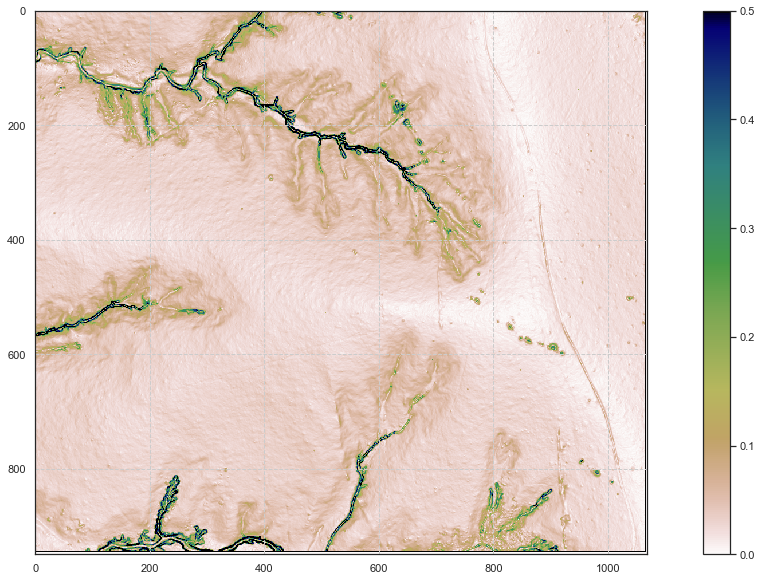

In [1412]:
plt.figure(figsize=(20,10));
plt.imshow(slope, cmap="gist_earth_r", vmax = 0.5);
plt.colorbar();

## Specific the size of the area to be checked. This represents a physical distance from the outlet but has no unit of measure.

In [1413]:
distance_from_outlet = 20

## Move upstream from the point 5m downstream until the gully head position is found. The first input is the maximum upstream distance checked.

In [1414]:
len(gh_list)

73

In [1415]:
final_gh_and_5m_downstream, gullies_to_keep_dict = upstreamDrainageLine(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area, DFME,gh_list, step_s, comp_d, dfme_threshold, 
                                                                        gh_min_elev)

840
(41, 41)
841
842
802
803
763
764
724
725
726
686
646
606
566
526
486
446
406
366
325
285
[289.23886108398438, 289.34860229492188, 289.39022827148438, 289.49386596679688, 289.63400268554688, 289.69894409179688, 289.83419799804688, 289.90130615234375, 289.96176147460938, 290.00482177734375, 290.04135131835938, 290.11856079101563, 290.19052124023438, 290.2626953125, 290.34951782226563, 290.4287109375, 290.5953369140625, 290.68984985351563, 290.75830078125, 290.88275146484375]
node:  144837
minimum downstream value:  -0.163507067393
mean upstream value:  -0.0851479541124
std upstream value:  0.00695484723767
minimum downstream value:  -0.137033864774
mean upstream value:  -0.0881256671334
std upstream value:  0.010932754036
minimum downstream value:  -0.125683345183
mean upstream value:  -0.102025137284
std upstream value:  0.0198891252608
minimum downstream value:  -0.0960091520101
mean upstream value:  -0.123272693519
std upstream value:  0.0155639493448
minimum downstream value:  -0

840
(41, 41)
881
922
962
1003
1043
1084
1125
1166
1207
1247
1287
1327
1368
1409
1449
1490
1531
1571
1612
1611
[289.67242431640625, 289.82470703125, 290.24154663085938, 290.865478515625, 290.90957641601563, 290.94863891601563, 290.99588012695313, 291.02435302734375, 291.06314086914063, 291.08636474609375, 291.12991333007813, 291.17538452148438, 291.2005615234375, 291.2330322265625, 291.26589965820313, 291.28079223632813, 291.31246948242188, 291.34014892578125, 291.36196899414063, 291.37994384765625]
node:  236932
minimum downstream value:  -0.183942193657
mean upstream value:  -0.00590231944953
std upstream value:  0.00834714021498
minimum downstream value:  -0.0
mean upstream value:  -0.0129615051604
std upstream value:  0.00927403996815
minimum downstream value:  -0.0
mean upstream value:  -0.0195989702909
std upstream value:  0.0014340944762
minimum downstream value:  -0.0
mean upstream value:  -0.0208857954177
std upstream value:  0.000706461439586
minimum downstream value:  -0.0
me

840
(41, 41)
841
842
843
844
845
846
847
848
849
850
851
852
894
895
896
897
898
899
900
941
[293.8720703125, 294.09201049804688, 294.54248046875, 294.62939453125, 294.69131469726563, 294.76593017578125, 294.85223388671875, 294.89117431640625, 294.93032836914063, 294.98062133789063, 295.0257568359375, 295.06900024414063, 295.08380126953125, 295.09994506835938, 295.1494140625, 295.17352294921875, 295.19540405273438, 295.24789428710938, 295.29058837890625, 295.32284545898438]
node:  306683
minimum downstream value:  -0.176600140349
mean upstream value:  -0.045953033833
std upstream value:  0.00174103232359
minimum downstream value:  -0.108080334602
mean upstream value:  -0.0440401417892
std upstream value:  0.00102636130857
minimum downstream value:  -0.0778906255987
mean upstream value:  -0.042179077343
std upstream value:  0.00202496356104
minimum downstream value:  -0.0595272397422
mean upstream value:  -0.0392734325366
std upstream value:  0.00284895356101
minimum downstream value:  

840
(41, 41)
882
924
966
967
1009
1051
1093
1134
1176
1217
1258
1300
1341
1382
1423
1465
1507
1508
1468
1469
[296.68331909179688, 296.73895263671875, 296.77719116210938, 296.82452392578125, 296.96200561523438, 297.03240966796875, 297.0706787109375, 297.09814453125, 297.0587158203125, 297.13717651367188, 297.18951416015625, 297.12335205078125, 297.13967895507813, 297.159912109375, 297.2188720703125, 297.30499267578125, 297.3800048828125, 297.46603393554688, 297.64605712890625, 297.77557373046875]
node:  388045
minimum downstream value:  -0.172430662962
mean upstream value:  -0.151435427705
std upstream value:  0.00613066788272
minimum downstream value:  -0.154249395655
mean upstream value:  -0.149182744025
std upstream value:  0.00784020809354
minimum downstream value:  -0.13801466644
mean upstream value:  -0.145002360485
std upstream value:  0.0111180176444
minimum downstream value:  -0.136772668783
mean upstream value:  -0.153439184834
std upstream value:  0.0227781717556
minimum down

840
(41, 41)
882
924
966
1008
1050
1091
1132
1174
1215
1257
1298
1340
1382
1423
1464
1505
1547
1588
1630
1631
[299.38381958007813, 299.45065307617188, 299.49496459960938, 299.38656616210938, 299.628662109375, 299.83404541015625, 299.95211791992188, 299.97467041015625, 300.00033569335938, 300.02120971679688, 300.03164672851563, 300.06491088867188, 300.09686279296875, 300.134521484375, 300.19540405273438, 300.25888061523438, 300.32962036132813, 300.3416748046875, 300.42129516601563, 300.4678955078125]
node:  459753
minimum downstream value:  -0.178223059121
mean upstream value:  -0.0725502256294
std upstream value:  0.0026080495919
minimum downstream value:  -0.183014828834
mean upstream value:  -0.081802994053
std upstream value:  0.0113221682468
minimum downstream value:  -0.154689022983
mean upstream value:  -0.0932418037971
std upstream value:  0.0126126730007
minimum downstream value:  -0.112045739595
mean upstream value:  -0.107683926485
std upstream value:  0.00897229998417
minimu

840
(41, 41)
841
842
843
803
804
805
765
725
726
686
646
606
607
567
568
528
488
489
449
448
[287.67550659179688, 287.62319946289063, 288.4052734375, 288.64547729492188, 288.58670043945313, 288.666748046875, 288.65158081054688, 288.68154907226563, 288.85702514648438, 288.80630493164063, 288.73550415039063, 288.9088134765625, 288.82418823242188, 288.78915405273438, 289.0294189453125, 288.83056640625, 288.97921752929688, 289.06561279296875, 289.15316772460938, 289.2176513671875]
node:  544774
minimum downstream value:  -0.283801188653
mean upstream value:  -0.200644675224
std upstream value:  0.0224540496017
minimum downstream value:  -0.207498157166
mean upstream value:  -0.184270562771
std upstream value:  0.0163725347075
840
(41, 41)
841
842
884
885
886
928
888
848
807
766
725
684
643
602
561
520
479
438
397
356
[290.89883422851563, 290.9661865234375, 291.11181640625, 291.11563110351563, 291.09515380859375, 291.37451171875, 291.40689086914063, 291.55438232421875, 291.59487915039063, 2

840
(41, 41)
882
924
925
967
968
969
1011
1053
1095
1096
1097
1139
1140
1141
1142
1143
1185
1227
1228
1269
[286.7030029296875, 286.80517578125, 286.87969970703125, 287.05038452148438, 287.0748291015625, 287.35565185546875, 287.453369140625, 287.543701171875, 287.60177612304688, 287.63705444335938, 287.6751708984375, 287.75408935546875, 287.79464721679688, 287.85134887695313, 287.90054321289063, 287.96829223632813, 288.04641723632813, 288.12188720703125, 288.16290283203125, 288.18685913085938]
node:  633491
minimum downstream value:  -0.1582311482
mean upstream value:  -0.0108155736909
std upstream value:  0.00493442893216
minimum downstream value:  -0.110851789247
mean upstream value:  -0.0154088982764
std upstream value:  0.00675129429499
minimum downstream value:  -0.0770610675807
mean upstream value:  -0.0211517634819
std upstream value:  0.00250872744945
minimum downstream value:  -0.0315584251172
mean upstream value:  -0.0224299871636
std upstream value:  0.000809178750704
minimum

840
(41, 41)
799
758
717
676
635
594
553
512
471
430
389
348
307
267
227
187
146
106
66
65
[297.36422729492188, 297.45648193359375, 297.53228759765625, 297.60858154296875, 297.68344116210938, 297.79122924804688, 297.83001708984375, 297.865478515625, 297.89602661132813, 297.9296875, 297.9560546875, 297.99600219726563, 298.02236938476563, 298.0643310546875, 298.11456298828125, 298.10092163085938, 298.11380004882813, 298.08493041992188, 298.11459350585938, 298.21090698242188]
node:  701471
minimum downstream value:  -0.146402910162
mean upstream value:  -0.074920687944
std upstream value:  0.00476741527991
minimum downstream value:  -0.130703563375
mean upstream value:  -0.0808242394057
std upstream value:  0.00573159111477
minimum downstream value:  -0.104515127708
mean upstream value:  -0.0863482325215
std upstream value:  0.00370842130307
minimum downstream value:  -0.0795879991284
mean upstream value:  -0.0894908877377
std upstream value:  0.00136967916224
minimum downstream value:  -

840
(41, 41)
800
760
761
762
763
723
724
725
726
686
687
647
607
608
568
569
570
530
531
490
[296.27902221679688, 296.30307006835938, 296.332763671875, 296.43634033203125, 296.48223876953125, 296.60906982421875, 296.67974853515625, 296.75723266601563, 296.83975219726563, 296.9395751953125, 297.0079345703125, 297.06442260742188, 297.123779296875, 297.1671142578125, 297.23739624023438, 297.28582763671875, 297.33792114257813, 297.41317749023438, 297.45001220703125, 297.48117065429688]
node:  759286
minimum downstream value:  -0.105599078089
mean upstream value:  -0.0604432275174
std upstream value:  0.0163178887084
minimum downstream value:  -0.110454065078
mean upstream value:  -0.0402709032071
std upstream value:  0.0168593377502
minimum downstream value:  -0.108472776678
mean upstream value:  -0.0224687619319
std upstream value:  0.0134835755209
minimum downstream value:  -0.100083174509
mean upstream value:  -0.0120458617701
std upstream value:  0.00540944324118
minimum downstream val

840
(41, 41)
799
758
717
676
635
594
553
513
472
431
390
349
308
267
226
185
144
103
62
61
[293.99664306640625, 293.95004272460938, 294.32296752929688, 294.78094482421875, 294.830078125, 294.8699951171875, 294.91018676757813, 294.9359130859375, 294.96359252929688, 295.00857543945313, 295.03884887695313, 295.08187866210938, 295.15292358398438, 295.21414184570313, 295.25640869140625, 295.28424072265625, 295.30862426757813, 295.33892822265625, 295.3704833984375, 295.381103515625]
node:  797761
minimum downstream value:  -0.157602504543
mean upstream value:  -0.0519250529784
std upstream value:  0.00720914214524
minimum downstream value:  -0.0383053955604
mean upstream value:  -0.0566111248439
std upstream value:  0.000616357931502
minimum downstream value:  -0.00733642303186
mean upstream value:  -0.0547794790462
std upstream value:  0.0025571577337
minimum downstream value:  -0.00733642303186
mean upstream value:  -0.049215814216
std upstream value:  0.00637407893401
minimum downstream v

840
(41, 41)
841
801
802
803
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
736
[291.76565551757813, 291.9375, 292.07827758789063, 292.1845703125, 292.23687744140625, 292.38348388671875, 292.75048828125, 292.85772705078125, 292.92755126953125, 292.98770141601563, 293.03607177734375, 293.07861328125, 293.15414428710938, 293.206298828125, 293.26214599609375, 293.31500244140625, 293.3626708984375, 293.42208862304688, 293.48321533203125, 293.48748779296875]
node:  889743
minimum downstream value:  -0.235212753183
mean upstream value:  -0.0287599618251
std upstream value:  0.0297359473137
840
(41, 41)
841
800
760
720
680
681
641
600
560
520
480
440
400
401
402
403
404
405
406
365
[296.60122680664063, 296.66116333007813, 297.04440307617188, 297.80203247070313, 297.87673950195313, 297.893798828125, 297.94937133789063, 297.97842407226563, 298.02301025390625, 298.0816650390625, 298.12997436523438, 298.17971801757813, 298.19979858398438, 298.22515869140625, 298.264892578125, 298.310

### In the final gully head dictionary the key is the point 5 m downstream of the gully head (later CP) and the value is the gully head found by moving back upstream (later GH)

In [1416]:
final_and_5m_df = pd.DataFrame.from_dict(final_gh_and_5m_downstream, orient='index')
final_and_5m_df['5m'] = final_and_5m_df.index
initial_cp_5m_final_df = initial_head_cp_5m_df.merge(final_and_5m_df, on="5m", how = 'inner')
initial_cp_5m_final_df.rename(columns={0: 'final'}, inplace=True)

In [1417]:
len(initial_cp_5m_final_df)

26

In [1418]:
final_5m_downstream, final_gully_heads = get_values(final_gh_and_5m_downstream)

### The final argument in the upstreamSlope function below tells it how far upstream of the gully head to first measure elevation for drainage_slope or slope for GHSlope

In [1419]:

slope_above_head, elevation_above_head = upstreamSlope(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area, DFME,final_gully_heads, step_s, comp_d, 5);

slope_above_head_df = pd.DataFrame.from_dict(slope_above_head, orient='index');
slope_above_head_df.rename(columns={0: 'GHSlope', 1: 'final'}, inplace=True);

elevation_above_head_df = pd.DataFrame.from_dict(elevation_above_head, orient='index');
elevation_above_head_df.rename(columns={0: 'GHelevation', 1: 'final'}, inplace=True);

840
(41, 41)
800
760
720
680
640
600
5   5
601
561
521
481
441
401
361
321
281
241
201
161
121
80
840
(41, 41)
841
842
802
803
763
723
5   5
724
684
644
645
605
565
525
485
445
405
365
325
285
244
840
(41, 41)
881
922
963
1003
1043
1084
5   5
1124
1165
1206
1247
1288
1329
1371
1412
1453
1494
1535
1577
1618
1619
840
(41, 41)
881
922
963
1004
1045
1086
5   5
1127
1169
1210
1251
1292
1334
1375
1416
1457
1498
1539
1580
1621
1620
840
(41, 41)
882
924
966
1008
1050
1092
5   5
1134
1175
1217
1258
1299
1341
1382
1423
1464
1506
1548
1549
1509
1510
840
(41, 41)
800
801
802
803
804
764
5   5
765
766
726
727
728
688
689
690
691
692
693
653
654
613
840
(41, 41)
800
760
720
679
639
598
5   5
557
517
476
436
395
355
314
274
234
193
153
113
72
73
840
(41, 41)
800
801
761
721
681
682
5   5
642
643
603
563
564
524
525
485
486
446
406
366
326
285
840
(41, 41)
882
883
884
885
845
846
5   5
847
807
767
768
728
688
689
649
609
569
570
530
531
571
840
(41, 41)
800
801
761
762
722
682
5   5
683
643
644
645
64

In [1420]:
slope_and_elevation_5m_df = slope_above_head_df.merge(elevation_above_head_df, on="final", how = 'inner')

In [1421]:
slope_above_head_10m, elevation_above_head_10m = upstreamSlope(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area, DFME,final_gully_heads, step_s, comp_d, 10);

slope_above_head_10m_df = pd.DataFrame.from_dict(slope_above_head_10m, orient='index');
slope_above_head_10m_df.rename(columns={0: 'GHSlope10', 1: 'final'}, inplace=True);

elevation_above_head_10m_df = pd.DataFrame.from_dict(elevation_above_head_10m, orient='index');
elevation_above_head_10m_df.rename(columns={0: 'GHelevation10', 1: 'final'}, inplace=True);

840
(41, 41)
800
760
720
680
640
600
601
561
521
481
441
10   10
401
361
321
281
241
201
161
121
80
840
(41, 41)
841
842
802
803
763
723
724
684
644
645
605
10   10
565
525
485
445
405
365
325
285
244
840
(41, 41)
881
922
963
1003
1043
1084
1124
1165
1206
1247
1288
10   10
1329
1371
1412
1453
1494
1535
1577
1618
1619
840
(41, 41)
881
922
963
1004
1045
1086
1127
1169
1210
1251
1292
10   10
1334
1375
1416
1457
1498
1539
1580
1621
1620
840
(41, 41)
882
924
966
1008
1050
1092
1134
1175
1217
1258
1299
10   10
1341
1382
1423
1464
1506
1548
1549
1509
1510
840
(41, 41)
800
801
802
803
804
764
765
766
726
727
728
10   10
688
689
690
691
692
693
653
654
613
840
(41, 41)
800
760
720
679
639
598
557
517
476
436
395
10   10
355
314
274
234
193
153
113
72
73
840
(41, 41)
800
801
761
721
681
682
642
643
603
563
564
10   10
524
525
485
486
446
406
366
326
285
840
(41, 41)
882
883
884
885
845
846
847
807
767
768
728
10   10
688
689
649
609
569
570
530
531
571
840
(41, 41)
800
801
761
762
722
682
683
64

In [1422]:
slope_10m_df = slope_and_elevation_5m_df.merge(slope_above_head_10m_df, on="final", how = 'inner')
slope_and_elevation_10m_df = slope_10m_df.merge(elevation_above_head_10m_df, on="final", how = 'inner')

In [1423]:
slope_above_head_15m, elevation_above_head_15m = upstreamSlope(20, input_DEM_resolution, grid_nodes, 
                                       input_DEM, catchment_area, DFME,final_gully_heads, step_s, comp_d, 15);

slope_above_head_15m_df = pd.DataFrame.from_dict(slope_above_head_15m, orient='index');
slope_above_head_15m_df.rename(columns={0: 'GHSlope15', 1: 'final'}, inplace=True);

elevation_above_head_15m_df = pd.DataFrame.from_dict(elevation_above_head_15m, orient='index');
elevation_above_head_15m_df.rename(columns={0: 'GHelevation15', 1: 'final'}, inplace=True);

840
(41, 41)
800
760
720
680
640
600
601
561
521
481
441
401
361
321
281
241
15   15
201
161
121
80
840
(41, 41)
841
842
802
803
763
723
724
684
644
645
605
565
525
485
445
405
15   15
365
325
285
244
840
(41, 41)
881
922
963
1003
1043
1084
1124
1165
1206
1247
1288
1329
1371
1412
1453
1494
15   15
1535
1577
1618
1619
840
(41, 41)
881
922
963
1004
1045
1086
1127
1169
1210
1251
1292
1334
1375
1416
1457
1498
15   15
1539
1580
1621
1620
840
(41, 41)
882
924
966
1008
1050
1092
1134
1175
1217
1258
1299
1341
1382
1423
1464
1506
15   15
1548
1549
1509
1510
840
(41, 41)
800
801
802
803
804
764
765
766
726
727
728
688
689
690
691
692
15   15
693
653
654
613
840
(41, 41)
800
760
720
679
639
598
557
517
476
436
395
355
314
274
234
193
15   15
153
113
72
73
840
(41, 41)
800
801
761
721
681
682
642
643
603
563
564
524
525
485
486
446
15   15
406
366
326
285
840
(41, 41)
882
883
884
885
845
846
847
807
767
768
728
688
689
649
609
569
15   15
570
530
531
571
840
(41, 41)
800
801
761
762
722
682
683
64

In [1424]:
slope_df = slope_and_elevation_10m_df.merge(slope_above_head_15m_df, on="final", how = 'inner')
slope_and_elevation_df = slope_df.merge(elevation_above_head_15m_df, on="final", how = 'inner')

In [1425]:
def drainageSlope(e1,e2):
    return max((e2-e1)/5, 0.0001)

slope_and_elevation_df['drainage_slope_5_10'] = slope_and_elevation_df.apply(lambda x: drainageSlope(x['GHelevation'], x['GHelevation10']), axis=1)
 

In [1426]:
def drainageSlope(e1,e2):
    return max((e2-e1)/5, 0.0001)

slope_and_elevation_df['drainage_slope_10_15'] = slope_and_elevation_df.apply(lambda x: drainageSlope(x['GHelevation10'], x['GHelevation15']), axis=1)
 

In [1427]:
def slopeDifference(slope_5_10, slope_10_15):
    largest = np.maximum(slope_5_10, slope_10_15)
    smallest = np.minimum(slope_5_10, slope_10_15)
    ratio = largest/smallest
    return ratio
slope_and_elevation_df['drainage_slope_ratio'] = slope_and_elevation_df.apply(lambda x: slopeDifference(x['drainage_slope_5_10'], x['drainage_slope_10_15']), axis=1)

In [1428]:
slope_and_elevation_df

,GHSlope,final,GHelevation,GHSlope10,GHelevation10,GHSlope15,GHelevation15,drainage_slope_5_10,drainage_slope_10_15,drainage_slope_ratio
0,0.044444,183621,297.177216,0.037788,297.437897,0.033072,297.691498,0.052136,0.050720,1.027918
1,0.035132,192168,296.081879,0.068003,296.441742,0.055282,296.981659,0.071973,0.107983,1.500339
2,0.038969,279810,293.469879,0.044052,293.662689,0.022453,293.840149,0.038562,0.035492,1.086500
3,0.038707,307591,293.761719,0.036544,293.931488,0.014991,294.059875,0.033954,0.025677,1.322320
4,0.036988,386975,297.032410,0.070825,297.189514,0.051769,297.304993,0.031421,0.023096,1.360465
5,0.051158,519206,293.749847,0.047602,294.017120,0.058584,294.259674,0.053455,0.048511,1.101912
6,0.086843,531957,289.685760,0.072725,290.105896,0.063951,290.491882,0.084027,0.077197,1.088472
7,0.099934,542641,288.824188,0.055209,289.065613,0.110759,289.368866,0.048285,0.060651,1.256099
8,0.126300,557649,288.874634,0.211611,289.716095,0.127353,290.087311,0.168292,0.074243,2.266771
9,0.060150,563118,295.005005,0.056534,295.283630,0.047512,295.557617,0.055725,0.054797,1.016930


No handles with labels found to put in legend.


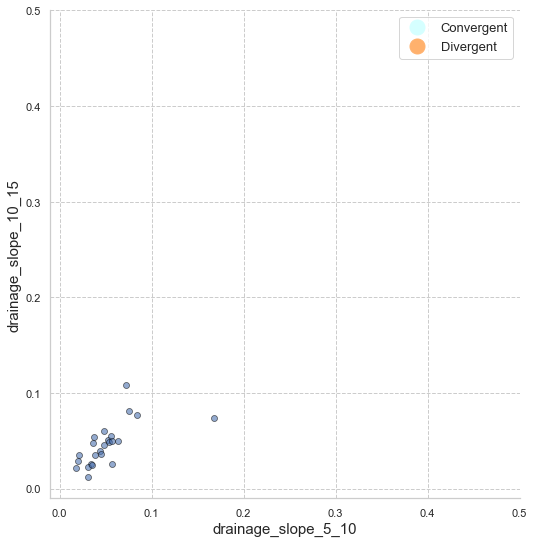

In [1429]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = slope_and_elevation_df
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'drainage_slope_5_10'
y_axis = 'drainage_slope_10_15'

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(-0.01,.5)
ax.set_ylim(-0.01,.5)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(x_axis, fontsize = 15)
ax.set_ylabel((y_axis), fontsize = 15)

#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(8,8)

In [1430]:
final_gully_head_nodes = np.isin(grid_nodes,final_gully_heads).astype('int64')

In [1431]:
len(final_gully_heads)


24

# Locate gully edges.

# Check whether gully edges meet same criteria as gully head earlier (can be modified), then locate edges next to 5m_downstream_points and gh.

In [1432]:
start_time = timeit.default_timer()

line_length = 20
list_of_final_gully_heads = []
gully_edges_dict = {}
for key, value in final_gh_and_5m_downstream.items():
    cp = key
    print('cp: ',cp)
    gh = value
    print('gh: ', gh)
    gh_lat = np.where(grid_nodes == gh)[0][0]
    cp_lat = np.where(grid_nodes == cp)[0][0]
    gh_lon = np.where(grid_nodes == gh)[1][0]
    cp_lon = np.where(grid_nodes == cp)[1][0]

    lat_displacement = cp_lat - gh_lat
    print('lat: ', lat_displacement)
    lon_displacement = gh_lon - cp_lon
    print('lon: ', lon_displacement)

    # a^2 + b^2 = c^2
    gully_length = np.sqrt(lat_displacement**2 + lon_displacement**2)
    
    gully_angle = gullyUnknownAngle(lat_displacement, lon_displacement)   
    
    gully_and_cross_section = GullyOrientation(gully_angle, key, mg.shape)
    
    approx_angle = gully_and_cross_section.closest_angle
        
    cross_section_nodes = gully_and_cross_section.cross_section(line_length)
    
    result = np.where(grid_nodes == key)
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    #################################################################################################
    # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
    # central grid node of the subset.
    subset_row_top = int(row_index - line_length)
    subset_row_bot = int(row_index + line_length) + 1
    subset_col_left = int(col_index - line_length)
    subset_col_right = int(col_index + line_length) + 1
    #################################################################################################
    # Restrict the size of the subset in cases where it is on the edge of a DEM.
    subset_row_top_adjusted = max(subset_row_top, 0);
    subset_row_bot_adjusted = min(subset_row_bot, input_DEM.shape[0]);
    subset_col_left_adjusted = max(subset_col_left, 0);
    subset_col_right_adjusted = min(subset_col_right, input_DEM.shape[1]);
    #################################################################################################
    # Find the offset required by restricting the size of the subset around DEM edges.
    # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
    offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
    offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
    offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
    offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
    #################################################################################################
    # Create subset around the current gully head grid node. 
    grid_nodes_subset_copy = np.copy(grid_nodes).astype('int32');
    grid_nodes_subset = grid_nodes_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    lat = grid_nodes_subset.shape[0]
    lon = grid_nodes_subset.shape[1]

    nodes_1d = np.squeeze(grid_nodes_subset.reshape(1, lat * lon))

    cross_section_subset_mask = np.isin(nodes_1d,cross_section_nodes).reshape(grid_nodes_subset.shape)
    cross_section_subset_image = cross_section_subset_mask.astype('int64')

    #################################################################################################
    # Take subsets of desired surface parameters for gulyl analysis (e.g. DFME, slope, curvature etc)
    #################################################################################################
    elevation_subset_copy = np.copy(input_DEM).astype('float32');
    cross_section_elevation = elevation_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    cross_section_elevation[~cross_section_subset_mask] = np.nan
    cross_section_elevation_1d = np.squeeze(cross_section_elevation.reshape(1, lat * lon))
    #################################################################################################
    dfme_subset_copy = np.copy(DFME).astype('float32');
    cross_section_dfme = dfme_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                 subset_col_left_adjusted:subset_col_right_adjusted]

    cross_section_dfme[~cross_section_subset_mask] = np.nan
    cross_section_dfme_1d = np.squeeze(cross_section_dfme.reshape(1, lat * lon))
    #################################################################################################
    
    node_cross_section_dfme_dict = {}
    for A, B in zip(nodes_1d, cross_section_dfme_1d):
        node_cross_section_dfme_dict[A] = B
    
    node_cross_section_elevation_dict = {}
    for A, B in zip(nodes_1d, cross_section_elevation_1d):
        node_cross_section_elevation_dict[A] = B
        
    dfme_cross_section_unordered = { key:value for key, 
                                     value in node_cross_section_dfme_dict.items() if ~np.isnan(value) }

    elevation_cross_section_unordered = { key:value for key, 
                                         value in node_cross_section_elevation_dict.items() if ~np.isnan(value) }

    ds = [dfme_cross_section_unordered, elevation_cross_section_unordered]
    d = {}
    for k in dfme_cross_section_unordered.keys():
        d[k] = tuple(d[k] for d in ds)

    cross_section_parameters = pd.DataFrame.from_dict(d)

    cross_section_parameters.rename(index={0:'DFME', 1:'Elevation'}, inplace=True)

    cross_section_parameters_transpose = cross_section_parameters.T

    cross_section_parameters_transpose.insert(0, "Distance", 0)
    
    for j in range(0, (line_length * 2)+1):
        if j < line_length:
            cross_section_parameters_transpose.iloc[j,0] = -line_length + j
        else:
            cross_section_parameters_transpose.iloc[j,0] = j - line_length
        
    cross_section_parameters_transpose['Node'] = cross_section_parameters_transpose.index.values
    
    dir1, dir1_nodes, dir2, dir2_nodes = assignDirection(cross_section_parameters_transpose, 
                                                 gully_and_cross_section.closest_angle)
    
    dir1e, dir1_nodes, dir2e, dir2_nodes = assignDirectionElev(cross_section_parameters_transpose, 
                                             gully_and_cross_section.closest_angle)
    


    #outcome_d1, D1 = checkGullyEdges(dir1,step_s,comp_d,-0.2,-0.2)
    #outcome_d2, D2 = checkGullyEdges(dir2,step_s,comp_d,-0.2,-0.2)
    
    outcome_d1, D1 = checkGullyEdgesElev(dir1,dir1e, step_s,comp_d,dfme_threshold,gh_min_elev, gh_relief);
    outcome_d2, D2 = checkGullyEdgesElev(dir2, dir2e, step_s,comp_d,dfme_threshold,gh_min_elev, gh_relief);
    
    if outcome_d1 == 'yes' and outcome_d2 == 'yes':
        list_of_final_gully_heads.append(key)
        # Directions will depend on orientation so need two sets of schemes.
        if approx_angle == 180 or approx_angle == 225 or approx_angle == 270 or approx_angle == 315:
            
            points_next_to_head_d1 = pointsAlongGully(dir1_nodes[D1], approx_angle, 5, grid_nodes)
            points_next_to_head_d2 = pointsAlongGully(dir2_nodes[D2], approx_angle, 5, grid_nodes)
            
            print('d1 : ', dir1_nodes[D1], 'd2: ', dir2_nodes[D2], 'New points: ', 
                  points_next_to_head_d1, points_next_to_head_d2, 'angle: ', approx_angle)
            
            gully_edges_dict[key] = [dir1_nodes[D1], dir2_nodes[D2], points_next_to_head_d1, points_next_to_head_d2]
            
        else:
            points_next_to_head_d1 = pointsAlongGully(dir1_nodes[D1], approx_angle, 5, grid_nodes)
            points_next_to_head_d2 = pointsAlongGully(dir2_nodes[D2], approx_angle, 5, grid_nodes)
            
            print('d1 : ', dir1_nodes[D1], 'd2: ', dir2_nodes[D2], 'New points: ', 
                  points_next_to_head_d1, points_next_to_head_d2, 'angle: ', approx_angle)
            
            gully_edges_dict[key] = [dir2_nodes[D2],dir1_nodes[D1], points_next_to_head_d2, points_next_to_head_d1]
        
    else:
        print('no')

    
timeit.default_timer() - start_time

cp:  188965
gh:  183621
lat:  5
lon:  6
Quadrant = Q1 min angle 0 max angle 90
northeast-southwest gully
elevation difference:  2.5842590332
elevation difference:  1.86895751953
elevation difference:  0.896484375
elevation difference:  -0.0331726074219
elevation difference:  -1.51266479492
elevation difference:  -2.2760925293
elevation difference:  -2.34378051758
elevation difference:  -2.16149902344
elevation difference:  -1.67153930664
elevation difference:  -1.05084228516
elevation difference:  0.385467529297
elevation difference:  0.940216064453
elevation difference:  0.439514160156
no
cp:  198582
gh:  192168
lat:  6
lon:  6
Quadrant = Q1 min angle 0 max angle 90
northeast-southwest gully
elevation difference:  0.780151367188
elevation difference:  0.545532226563
elevation difference:  0.276184082031
elevation difference:  0.204895019531
elevation difference:  0.185791015625
elevation difference:  0.183319091797
elevation difference:  -0.139801025391
elevation difference:  -0.14297

elevation difference:  0.274810791016
elevation difference:  0.234802246094
elevation difference:  0.227722167969
elevation difference:  0.201904296875
elevation difference:  0.171112060547
elevation difference:  0.107940673828
elevation difference:  0.0643310546875
elevation difference:  0.0796813964844
elevation difference:  0.0832824707031
elevation difference:  0.113189697266
elevation difference:  0.12353515625
elevation difference:  0.142639160156
elevation difference:  0.376007080078
elevation difference:  0.359588623047
elevation difference:  0.329010009766
elevation difference:  0.310089111328
elevation difference:  0.290771484375
elevation difference:  0.278015136719
elevation difference:  0.282928466797
elevation difference:  0.282012939453
elevation difference:  0.269989013672
elevation difference:  0.284454345703
elevation difference:  0.278442382813
elevation difference:  0.277069091797
no
cp:  887836
gh:  881415
lat:  6
lon:  -1
Quadrant = Q2 min angle 270 max angle 360


1.9401061000098707

# Check the list of final gully heads.

In [1433]:
final_5m_downstream_nodes = np.isin(grid_nodes,list_of_final_gully_heads).astype('int64')
len(list_of_final_gully_heads)

16

In [1434]:
gully_edges_df = pd.DataFrame.from_dict(gully_edges_dict).T
gully_edges_df.columns = ['LeftCP', 'RightCP', 'LeftGH', 'RightGH']
gully_edges_df['5m'] = gully_edges_df.index
initial_cp_5m_final_edges_df = initial_cp_5m_final_df.merge(gully_edges_df, on="5m", how = 'inner')

## Compare drainage area of final gh to cp and initial gh and throw out any with large differences.

In [1435]:
final_gh_da = initial_cp_5m_final_edges_df['final'].values.tolist() 

In [1436]:
fgh_da_dict = {}

for i in final_gh_da:
    result = np.where(grid_nodes == i);
    #################################################################################################
    # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
    row_index = result[0][0];
    col_index = result[1][0];
    fgh_da = catchment_area[row_index,col_index];
    fgh_da_dict[i] = np.round(fgh_da, 5);
    
fgh_da_df = pd.DataFrame.from_dict(fgh_da_dict, orient='index')
fgh_da_df['final'] = fgh_da_df.index
initial_cp_5m_final_da_df = initial_cp_5m_final_edges_df.merge(fgh_da_df, on="final", how = 'inner')
initial_cp_5m_final_da_df.rename(columns={0: 'fgh_area'}, inplace=True)


In [1437]:
final_gh_copy = initial_cp_5m_final_da_df.copy()

In [1438]:
#drainage_ratio_threshold = 5

In [1439]:
#def drainageDifference(drainage_cp, drainage_fgh):
#    return drainage_cp/drainage_fgh
#final_gh_copy['final_drainage_ratio'] = final_gh_copy.apply(lambda x: drainageDifference(x['area'], x['fgh_area']), axis=1)

In [1440]:
#final_gh_copy.drop(final_gh_copy[final_gh_copy['final_drainage_ratio'] > drainage_ratio_threshold].index, inplace = True) 

## Combine points around head with GH slope estimate.

In [1441]:
gully_topographic_data = final_gh_copy.merge(slope_and_elevation_df, on="final", how = 'inner')

In [1442]:
gully_topographic_data['GHSlopeMean'] = gully_topographic_data[['GHSlope', 'GHSlope10']].mean(axis=1)

## Extract each point seperately.

In [1443]:
left_edge_points = gully_edges_df['LeftCP'].values
right_edge_points = gully_edges_df['RightCP'].values
left_head_points = gully_edges_df['LeftGH'].values
right_head_points = gully_edges_df['RightGH'].values
gully_left_edges = np.isin(grid_nodes,left_edge_points).astype('int64')
gully_right_edges = np.isin(grid_nodes,right_edge_points).astype('int64')
gully_left_head = np.isin(grid_nodes,left_head_points).astype('int64')
gully_right_head = np.isin(grid_nodes,right_head_points).astype('int64')

left_cp_slope = getSlopeValues(left_edge_points, slope, grid_nodes)
right_cp_slope = getSlopeValues(right_edge_points, slope, grid_nodes)
left_head_slope = getSlopeValues(left_head_points, slope, grid_nodes)
right_head_slope = getSlopeValues(right_head_points, slope, grid_nodes)

left_cp_slope_df = pd.DataFrame.from_dict(left_cp_slope, orient='index')
left_cp_slope_df['LeftCP'] = left_cp_slope_df.index
all_data_plus_left_cp = gully_topographic_data.merge(left_cp_slope_df, on="LeftCP", how = 'inner')
all_data_plus_left_cp.rename(columns={0: 'LeftCPslope'}, inplace=True)

right_cp_slope_df = pd.DataFrame.from_dict(right_cp_slope, orient='index')
right_cp_slope_df['RightCP'] = right_cp_slope_df.index
all_data_plus_right_cp = all_data_plus_left_cp.merge(right_cp_slope_df, on="RightCP", how = 'inner')
all_data_plus_right_cp.rename(columns={0: 'RightCPslope'}, inplace=True)

left_head_slope_df = pd.DataFrame.from_dict(left_head_slope, orient='index')
left_head_slope_df['LeftGH'] = left_head_slope_df.index
all_data_plus_left_gh = all_data_plus_right_cp.merge(left_head_slope_df, on="LeftGH", how = 'inner')
all_data_plus_left_gh.rename(columns={0: 'LeftGHslope'}, inplace=True)

right_head_slope_df = pd.DataFrame.from_dict(right_head_slope, orient='index')
right_head_slope_df['RightGH'] = right_head_slope_df.index
all_data_plus_right_gh = all_data_plus_left_gh.merge(right_head_slope_df, on="RightGH", how = 'inner')
all_data_plus_right_gh.rename(columns={0: 'RightGHslope'}, inplace=True)

all_data_plus_right_gh['median'] = all_data_plus_right_gh[['LeftCPslope', 'RightCPslope','LeftGHslope','RightGHslope','GHSlope']].median(axis=1)
all_data_plus_right_gh['std'] = all_data_plus_right_gh[['LeftCPslope', 'RightCPslope','LeftGHslope','RightGHslope','GHSlope']].std(axis=1)



In [1444]:
gully_head_node_array = np.isin(grid_nodes,all_data_plus_right_gh['final'].values).astype('int64')

In [1445]:
filtered_standard_slope = all_data_plus_right_gh[all_data_plus_right_gh['std'] < 0.05] 
filtered_standard_slope_df = filtered_standard_slope.reset_index()

In [1446]:
filtered_drainage_slope = all_data_plus_right_gh[all_data_plus_right_gh['drainage_slope_ratio'] < 1.5] 
filtered_drainage_slope_df = filtered_drainage_slope.reset_index()

In [1447]:
slope_to_use = 'drainage_slope_5_10'

In [1448]:
data_to_plot = filtered_drainage_slope_df

In [1449]:
data_to_plot['log_area'] = np.log10(data_to_plot['area'])
data_to_plot['log_slope'] = np.log10(data_to_plot[slope_to_use])

In [1450]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

No handles with labels found to put in legend.


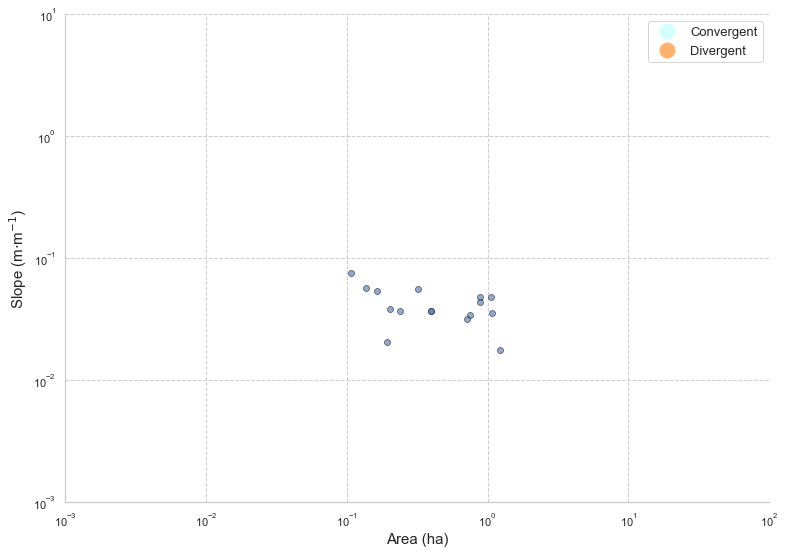

In [1451]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = data_to_plot
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'area'
y_axis = slope_to_use

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.001,100)
ax.set_ylim(0.001,10)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,8)

In [1452]:
data_used_by_model = thresholdLineOnlyCooks(data_to_plot, 'area', slope_to_use)

No handles with labels found to put in legend.


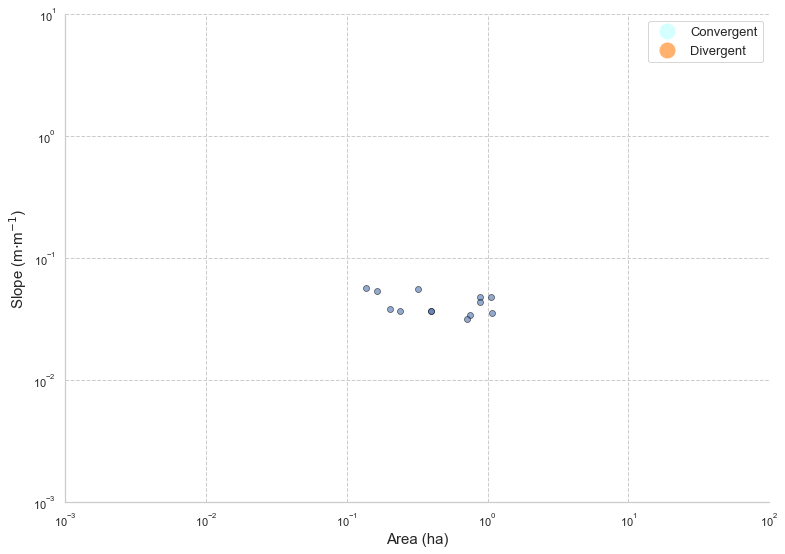

In [1453]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
# baby blue, pale pink
data = data_used_by_model
colours = {0:'xkcd:very light blue', 1:'xkcd:pumpkin'}
x_axis = 'area'
y_axis = slope_to_use

fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, 
                 data=data, alpha = 0.6,  edgecolor='xkcd:black', 
                   markers=['o', 'o'])

ax = fig.axes[0,0]
ax.set_xlim(0.001,100)
ax.set_ylim(0.001,10)
ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)
leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"


Div = Line2D([], [], color='xkcd:apricot', marker='o', linestyle='None',
                          markersize=15, label='Divergent')
Conv = Line2D([], [], color='xkcd:very light blue', marker='o', linestyle='None',
                          markersize=15, label='Convergent')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Area (ha)', fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)
ax.set(xscale="log", yscale="log")
#ax.set(xscale="log")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
plt.legend(handles=[Conv, Div],fontsize=13)
fig.fig.set_size_inches(12,8)

In [1454]:
orthogonal_regression_dataset = data_to_plot

In [1455]:
# Initiate some data, giving some randomness using random.random().
x = orthogonal_regression_dataset.loc[:,'log_area'].values
y = orthogonal_regression_dataset.loc[:,'log_slope'].values

# Define a function (quadratic in our case) to fit the data with.
def linear_func(p, x):
    m, c = p
    return m*x + c
   
# Create a model for fitting.
linear_model = Model(linear_func)

# Create a RealData object using our initiated data from above.
data = RealData(x, y)

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[-0.4, -1])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

Beta: [-0.21658898 -1.48761385]
Beta Std Error: [ 0.11000955  0.05687762]
Beta Covariance: [[ 0.55166541  0.21273564]
 [ 0.21273564  0.14746801]]
Residual Variance: 0.021937394729135324
Inverse Condition #: 0.2922698064195363
Reason(s) for Halting:
  Sum of squares convergence


In [1456]:
print('b: ', out.beta[0] *-1)
print('k: ', 10**out.beta[1])

b:  0.216588978079
k:  0.0325376477683


In [1457]:
b_orth = out.beta[0] 
k_orth = out.beta[1]

In [1458]:
k_adjustment_dataset = data_to_plot

In [1459]:
target_number_of_points_above_line = np.ceil(len(k_adjustment_dataset)*0.8).astype(int)
adjustment = 0
for u in range(0,100):
    above_model_line = []
    for j in k_adjustment_dataset.index:
        measured_slope = k_adjustment_dataset['log_slope'].loc[j]
        adjusted_intercept = k_orth - adjustment
        model_slope = b_orth * k_adjustment_dataset['log_area'].loc[j] + adjusted_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)                
        else:
            pass
    if len(above_model_line) >= target_number_of_points_above_line:
        break
    else:
        adjustment += 0.01
                

#corrected_set = regression_dataset.drop(above_model_line, axis='index')


# Generate graph

In [1460]:
exponent_b_to_use = b_orth*-1
scalar_k_to_use = 10**adjusted_intercept

In [1461]:
graph_data = data_to_plot

In [1462]:
model_parameter_k = scalar_k_to_use
model_parameter_b = exponent_b_to_use

In [1463]:
generate_area_values = np.arange(0.01, 10, 0.0001)
model_slope = model_parameter_k * (generate_area_values**-model_parameter_b )
df_model_area = pd.DataFrame(generate_area_values)
df_model_area.rename(columns={0: 'area'}, inplace=True)
graph_data['DC'] = 1
reshaped_model_slope = model_slope.reshape(-1,1)
df_model_slope = pd.DataFrame(reshaped_model_slope)
df_model_slope.rename(columns={0: slope_to_use}, inplace=True)
df_model = pd.concat([df_model_slope, df_model_area], axis=1, sort=False)
df_model['DC'] = 3
graph_data['Size'] = 500
df_model['Size'] = 1

df_all_1 = df_model.append(graph_data)

No handles with labels found to put in legend.


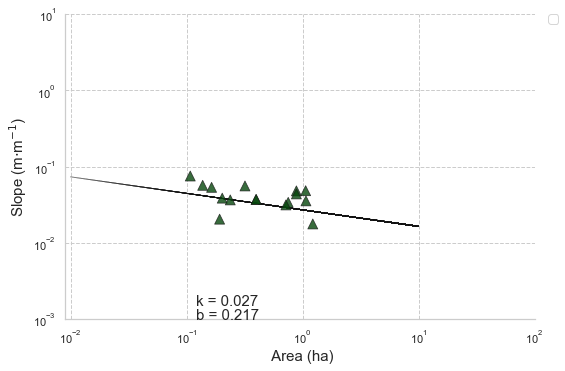

In [1464]:
sns.set_style('whitegrid', {'grid.linestyle': '--'})
data = df_all_1
colours = {1:'xkcd:forest green', 3:'xkcd:black', 4:'xkcd:forest green'}
x_axis = 'area'
#x_axis_label = x_axis + ' Area (ha)'
x_axis_label = ' Area (ha)'
y_axis = slope_to_use
fig = sns.relplot(x=x_axis, y=y_axis,  palette = colours, hue = 'DC', 
                 data=data, alpha = 0.8, legend = False, edgecolor="k", 
                  style = 'DC', size = 'Size', sizes = (0.1,100), markers =['^', '.', '.'])

ax = fig.axes[0,0]

ax.set_xlabel(x_axis, fontsize = 20)
ax.set_ylabel(y_axis, fontsize = 20)

fig.set(xlim = (0.009, 100))
fig.set(ylim = (0.001, 10))

leg = fig._legend
plt.rcParams["axes.edgecolor"] = "0.15"

#g1 = Line2D([], [], color='xkcd:orange', marker='s', linestyle='None',
#                          markersize=15, label='Gully head 1 (divergent)')

rs = Line2D([], [], color='xkcd:merlot', marker='^', linestyle='None',
                          markersize=15, label='Random sample (convergent)')

#g2 = Line2D([], [], color='xkcd:scarlet', marker='o', linestyle='None',
#                          markersize=15, label='Gully head 2 (divergent)')

#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(x_axis_label, fontsize = 15)
ax.set_ylabel(('Slope (m$\cdot$m$^{-1}$)'), fontsize = 15)

plt.legend(bbox_to_anchor=(1.05, 1),  borderaxespad=0.,fontsize='12')
plt.setp(ax.get_legend().get_title(), fontsize='12') # for legend title
#plt.legend(handles=[rs, g1, g2],fontsize=13, loc=3)
#plt.legend(handles=[rs],fontsize=13, loc=3)

ax.text(0.12, 0.0015,'k = ' + str(np.round(model_parameter_k, 3)), fontsize=15) 
ax.text(0.12, 0.001,'b = ' + str(np.round(model_parameter_b, 3)), fontsize=15)

ax.set_xscale('log')
ax.set_yscale('log')
fig.fig.set_size_inches(8,5)

In [ ]:
all_data_plus_right_gh

In [319]:
#all_data_plus_right_gh.to_csv('pg_8.csv')

In [1465]:
cp_node_array = np.isin(grid_nodes,all_data_plus_right_gh['cp'].values).astype('int64')

In [1466]:
initial_gh_node_array = np.isin(grid_nodes,all_data_plus_right_gh['initial'].values).astype('int64')

In [1467]:
downstream_5m_node_array = np.isin(grid_nodes,all_data_plus_right_gh['5m'].values).astype('int64')

In [1468]:
final_node_array = np.isin(grid_nodes,all_data_plus_right_gh['final'].values).astype('int64')

In [1469]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [1470]:
np_array_to_Geotiff('fann_fgh.tif', input_geotiff, final_node_array, catchment_area.dtype)
#np_array_to_Geotiff('bogie_ghs.tif', input_geotiff, gully_head_node_array, catchment_area.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


In [ ]:
np.sum(cp_node_array)

In [ ]:
list_of_exponents = []
list_of_scalars = []
for r in range(0, 10):
    if r == 0:
        exponent_b, scalar_k, data_used_by_model = thresholdLine(data_to_plot, 'area', slope_to_use)
        list_of_exponents.append(exponent_b)
        list_of_scalars.append(scalar_k)
    else:
        if len(data_used_by_model) > 30:
            exponent_b, scalar_k, data_used_by_model = thresholdLine(data_used_by_model, 'area', slope_to_use)
            list_of_exponents.append(exponent_b)
            list_of_scalars.append(scalar_k)
        else:
            break
        
exponent_to_use = max(list_of_exponents)
scalar_to_use = min(list_of_scalars)